In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.cbook import boxplot_stats

In [2]:
# colourblind-friendly palette from colour universal design (CUD)
# https://jfly.uni-koeln.de/color/
# https://nanx.me/oneclust/reference/cud.html
named_colors = {
    "black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())
sns.set_theme(style="whitegrid")

def cud(n: int = len(cud_palette), start: int = 0) -> list[str]:
    remainder = cud_palette[:start]
    palette = cud_palette[start:] + remainder
    return palette[:n]

In [3]:
samplesheet = pd.read_csv("../config/pep/samples.csv", index_col="sample_name")
samplesheet

species   taxid reads_dir  \
sample_name                                                          
ATCC_10708__202309           Salmonella_enterica   28901   source1   
ATCC_17802__202309       Vibrio_parahaemolyticus     670   source1   
ATCC_25922__202309              Escherichia_coli     562   source1   
ATCC_33560__202309          Campylobacter_jejuni     197   source1   
ATCC_35221__202309            Campylobacter_lari     201   source1   
ATCC_19119__202309             Listeria_ivanovii    1638   source1   
ATCC_35897__202309           Listeria_welshimeri    1643   source1   
ATCC_BAA-679__202309      Listeria_monocytogenes    1639   source1   
BPH2947__202310            Staphylococcus_aureus    1280   source1   
AJ292__202310               Klebsiella_variicola  244366   source1   
KPC2__202310               Klebsiella_pneumoniae     573   source1   
RDH275__202311            Streptococcus_pyogenes    1314   source1   
MMC234__202311        Streptococcus_dysgalactiae    1334   source1   
AMtb_1__202402        Mycobacterium_tuberculosis    1773   source1   

                     reference_path illumina_1 illumina_2  
sample_name                                                
ATCC_10708__202309          source2    source3    source4  
ATCC_17802__202309          source2    source3    source4  
ATCC_25922__202309          source2    source3    source4  
ATCC_33560__202309          source2    source3    source4  
ATCC_35221__202309          source2    source3    source4  
ATCC_19119__202309          source2    source3    source4  
ATCC_35897__202309          source2    source3    source4  
ATCC_BAA-679__202309        source2    source3    source4  
BPH2947__202310             source2    source3    source4  
AJ292__202310               source2    source3    source4  
KPC2__202310                source2    source3    source4  
RDH275__202311              source2    source3    source4  
MMC234__202311              source2    source3    source4  
AMtb_1__202402              source2    source3    source4

# Assessing self calls

In [4]:
df = pd.read_csv("../results/assess/self/self_calls.csv")
df.sort_values(by=["sample", "caller"], inplace=True)
# shorten model column from dna_r10.4.1_e8.2_400bps_fast@v4.3.0 to fast
df["model"] = df["model"].apply(lambda x: x.split("_")[-1].split("@")[0])
df.head()

SNP  INS   DEL  INDEL    FP   SNP_TN  INDEL_TN       TN       SNP_FPR  \
9    60  293   704    997  1057  5445072   5444135  5444075  1.101902e-05   
23    4    6    32     38    42  5445128   5445094  5445090  7.346011e-07   
37    0    0     7      7     7  5445132   5445125  5445125  0.000000e+00   
51  191   99  1141   1240  1431  5444941   5443892  5443701  3.507720e-05   
65    0    6   221    227   227  5445132   5444905  5444905  0.000000e+00   

    INDEL_FPR  ...  3bp_hom_del 4bp_hom_del 5+bp_hom_del   hom_del  \
9    0.000183  ...     0.032670    0.014205     0.002841  0.933239   
23   0.000007  ...     0.093750    0.062500     0.031250  0.937500   
37   0.000001  ...     0.000000    0.000000     0.000000  1.000000   
51   0.000228  ...     0.175285    0.049080     0.008764  0.744961   
65   0.000042  ...     0.425339    0.090498     0.013575  0.918552   

   2bp_hom_ins 3bp_hom_ins 4bp_hom_ins  5+bp_hom_ins   hom_ins  hom_indels  
9     0.023891    0.006826         0.0           0.0  0.921502    0.929789  
23    0.166667    0.000000         0.0           0.0  1.000000    0.947368  
37    0.000000    0.000000         0.0           0.0  0.000000    1.000000  
51    0.010101    0.010101         0.0           0.0  0.757576    0.745968  
65    0.000000    0.000000         0.0           0.0  0.833333    0.916300  

[5 rows x 28 columns]

In [5]:
# add SNP and INDEL FPR columns
df["seqlen"] = df["FP"] + df["TN"]
df["SNP_FPR"] = df["SNP"] / df["seqlen"]
df["INDEL_FPR"] = df["INDEL"] / df["seqlen"]
df["SNP_FP/Mbp"] = df["SNP"] / df["seqlen"] * 1e6
df["INDEL_FP/Mbp"] = df["INDEL"] / df["seqlen"] * 1e6
df["FP/Mbp"] = df["FP"] / df["seqlen"] * 1e6
df.head()

SNP  INS   DEL  INDEL    FP   SNP_TN  INDEL_TN       TN       SNP_FPR  \
9    60  293   704    997  1057  5445072   5444135  5444075  1.101902e-05   
23    4    6    32     38    42  5445128   5445094  5445090  7.346011e-07   
37    0    0     7      7     7  5445132   5445125  5445125  0.000000e+00   
51  191   99  1141   1240  1431  5444941   5443892  5443701  3.507720e-05   
65    0    6   221    227   227  5445132   5444905  5444905  0.000000e+00   

    INDEL_FPR  ...  2bp_hom_ins 3bp_hom_ins 4bp_hom_ins 5+bp_hom_ins  \
9    0.000183  ...     0.023891    0.006826         0.0          0.0   
23   0.000007  ...     0.166667    0.000000         0.0          0.0   
37   0.000001  ...     0.000000    0.000000         0.0          0.0   
51   0.000228  ...     0.010101    0.010101         0.0          0.0   
65   0.000042  ...     0.000000    0.000000         0.0          0.0   

     hom_ins hom_indels   seqlen  SNP_FP/Mbp  INDEL_FP/Mbp      FP/Mbp  
9   0.921502   0.929789  5445132   11.019017    183.099326  194.118343  
23  1.000000   0.947368  5445132    0.734601      6.978711    7.713312  
37  0.000000   1.000000  5445132    0.000000      1.285552    1.285552  
51  0.757576   0.745968  5445132   35.077203    227.726343  262.803546  
65  0.833333   0.916300  5445132    0.000000     41.688613   41.688613  

[5 rows x 32 columns]

Print the FPR rate for each sample, stratified into version, mode, model, depth, caller, and sample

In [6]:
fpr_rate = df.groupby(["version", "mode", "model", "depth", "caller", "sample"]).apply(lambda a: a[:])
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print(fpr_rate)

fpr_rate.to_latex("self_fpr_rate.tex", index=False, escape=True)
fpr_rate.to_string("self_fpr_rate.txt", index=False)

                                                                    SNP   INS  \
version mode    model depth caller      sample                                  
v4.3.0  duplex  fast  100x  bcftools    AJ292__202310        9       60   293   
                                        AMtb_1__202402       13     147   586   
                                        ATCC_10708__202309   0       24  1260   
                                        ATCC_17802__202309   1       15    60   
                                        ATCC_19119__202309   5        0    12   
                                        ATCC_25922__202309   2       40   124   
                                        ATCC_33560__202309   3      124   520   
                                        ATCC_35221__202309   4       55   333   
                                        ATCC_35897__202309   6        0    31   
                                        ATCC_BAA-679__202309 7        1    10   
                            

In [7]:
def plot_fpr(df, y, title=""):
    # plot fpr rate for each version, mode, model, depth, and caller
    row = "depth"
    nrows = len(df[row].unique())
    col = "mode"
    ncols = len(df[col].unique())
    hue = "model"
    x = "caller"
    palette = cud(n=len(df[hue].unique()))
    annotated_species = set()
    fig, axes = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        figsize=(10, 10),
        dpi=300,
        squeeze=False,
        sharey=True,
        tight_layout=True,
    )
    legend_drawn = False
    for i, version in enumerate(df[row].unique()):
        version_df = df.query(f"{row} == '{version}'")
        for j, mode in enumerate(version_df[col].unique()):
            mode_df = version_df.query(f"{col} == '{mode}'")
            ax = axes[i, j]
            sns.boxplot(
                x=x,
                y=y,
                data=mode_df,
                ax=ax,
                hue=hue,
                fill=False,
                fliersize=0,
                palette=palette,
                gap=0.2,
            )
            strip = sns.stripplot(
                x=x,
                y=y,
                data=mode_df,
                ax=ax,
                hue=hue,
                dodge=True,
                alpha=0.75,
                legend=False,
                linewidth=0.5,
                edgecolor="black",
                palette=palette,
            )

            for collection_i, collection in enumerate(strip.collections):
                caller_i = math.floor(collection_i / len(df[hue].unique()))  
                caller = mode_df[x].unique()[caller_i]   
                model_i = collection_i % len(df[hue].unique())
                offsets = collection.get_offsets()
                xs = []
                ys = []
                for xval, yval in offsets:
                    xs.append(xval)
                    ys.append(yval)
                
                stats = boxplot_stats(ys)[0]
                whishi = stats["whishi"]
                outliers = [y for y in stats["fliers"] if y > whishi]
                for ix, yval in enumerate(ys):
                    if yval in outliers:
                        # annotate with the name of sample that is an outlier
                        caller_df = mode_df.query(f"{x} == '{caller}'")
                        # get the index of the y value closest to the outlier
                        s_ix = (caller_df[y] - yval).abs().idxmin()
                        sample = caller_df["sample"].loc[s_ix]
                        species = samplesheet["species"].loc[sample]
                        annotated_species.add(species)
                        s = species.split("_")[0][0] + species.split("_")[1][0]
                        ax.annotate(
                            s,
                            (xs[ix], yval),
                            xycoords="data",
                            textcoords="offset points",
                            xytext=(3, 50),
                            ha="left",
                            va="bottom",
                            fontsize=6,
                            arrowprops=dict(arrowstyle="->", lw=1, color=cud()[model_i], relpos=(0, 1)),
                        )



            ax.set_title(f"{mode}")
            if "FPR" in y:
                ax.set_ylabel("FPR")
                ax.set_yscale("symlog", linthresh=0.0000001)
                yticks = [0, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01]
            elif "FP/Mbp" in y:
                ax.set_ylabel("FP/Mbp")
                ax.set_yscale("symlog", linthresh=1)
                yticks = [0, 1, 10, 100, 1000, 10000]
            else:
                ax.set_ylabel(y)
            ax.set_xlabel("Caller")
            
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks)
            # rotate x labels
            for tick in ax.get_xticklabels():
                tick.set_rotation(90)

            if legend_drawn:
                ax.get_legend().remove()
            else:
                ax.legend(loc="upper right", title=hue)
                legend_drawn = True

    # add a legend for the species initials
    if annotated_species:
        annotated_species = sorted(list(annotated_species))
        abbrevs = [s.split("_")[0][0] + s.split("_")[1][0] for s in annotated_species]
        handles = [
            plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="w", markersize=0)
        ] * len(annotated_species)
        labels = list([f"{a} = $\it{{{s.split('_')[0]}}}$ $\it{{{s.split('_')[1]}}}$" for a, s in zip(abbrevs, annotated_species)])
        axes[0,1].legend(
            handles,
            labels,
            loc="best",
            # title="Species",
            fontsize=6,
        )
                
    fig.suptitle(title, fontsize=16)

    return fig, axes

## Plotting overall FPR

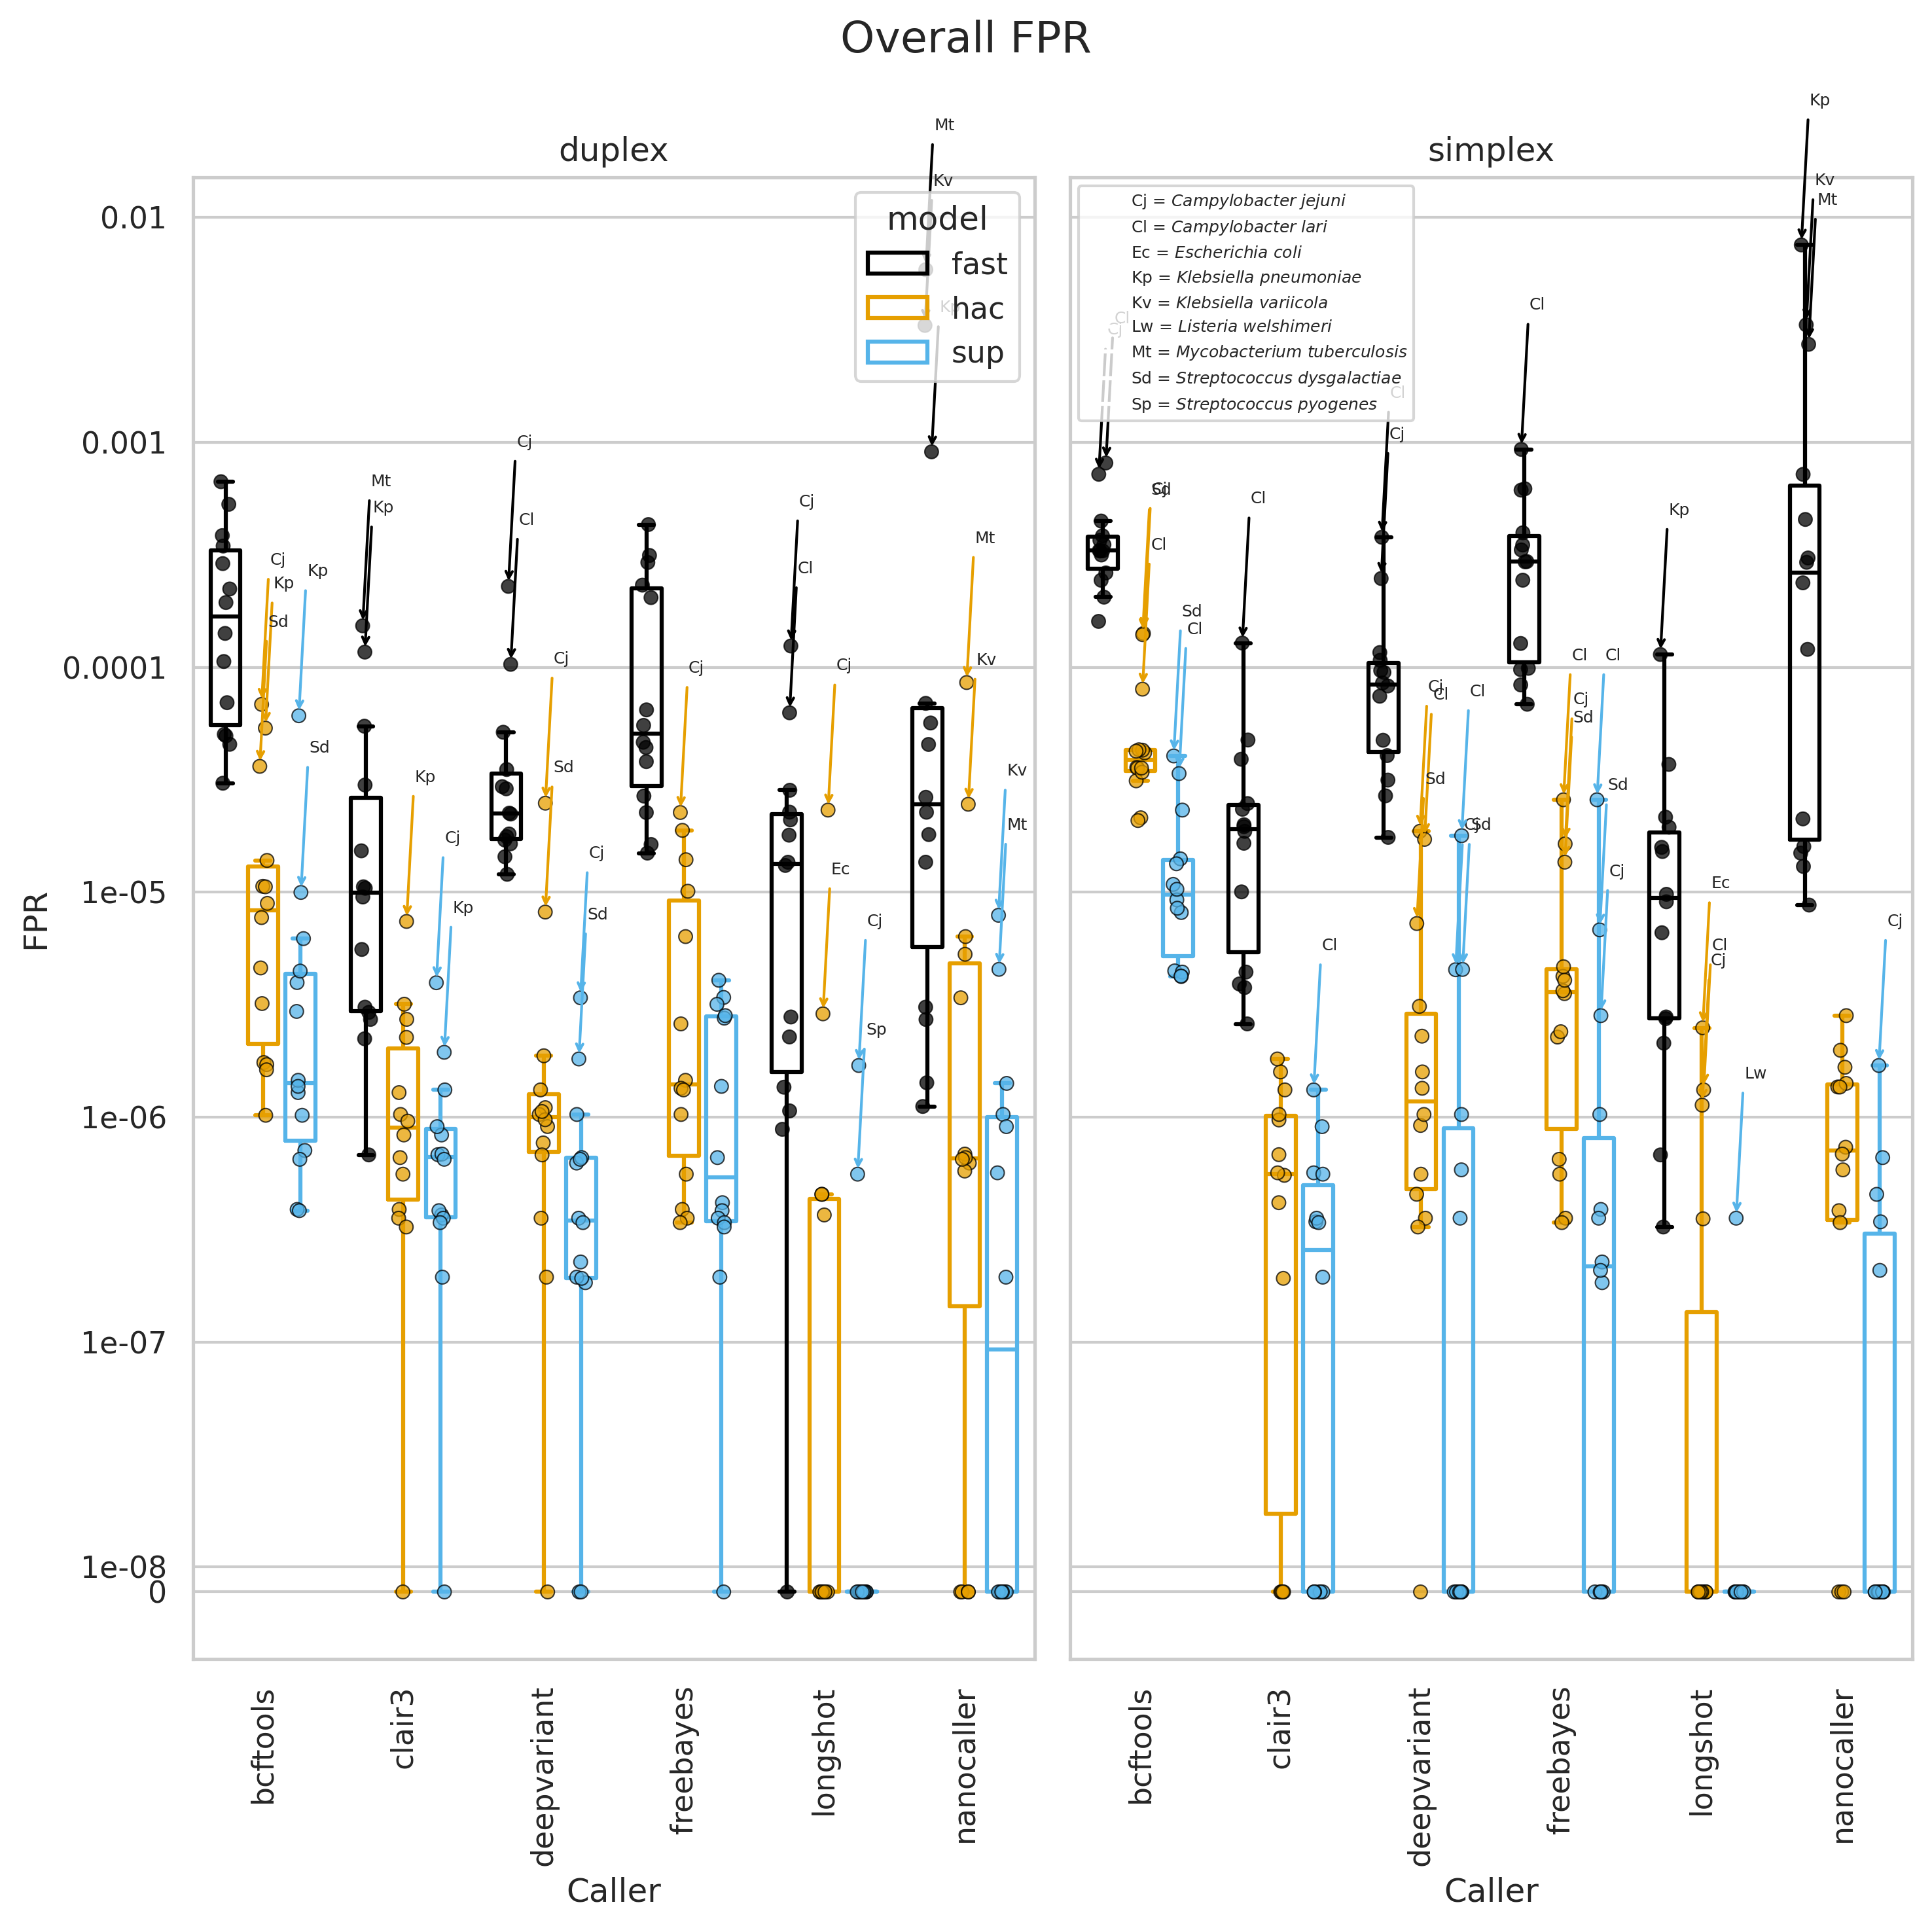

In [8]:
overall_fig, overall_axes = plot_fpr(df, "FPR", "Overall FPR")

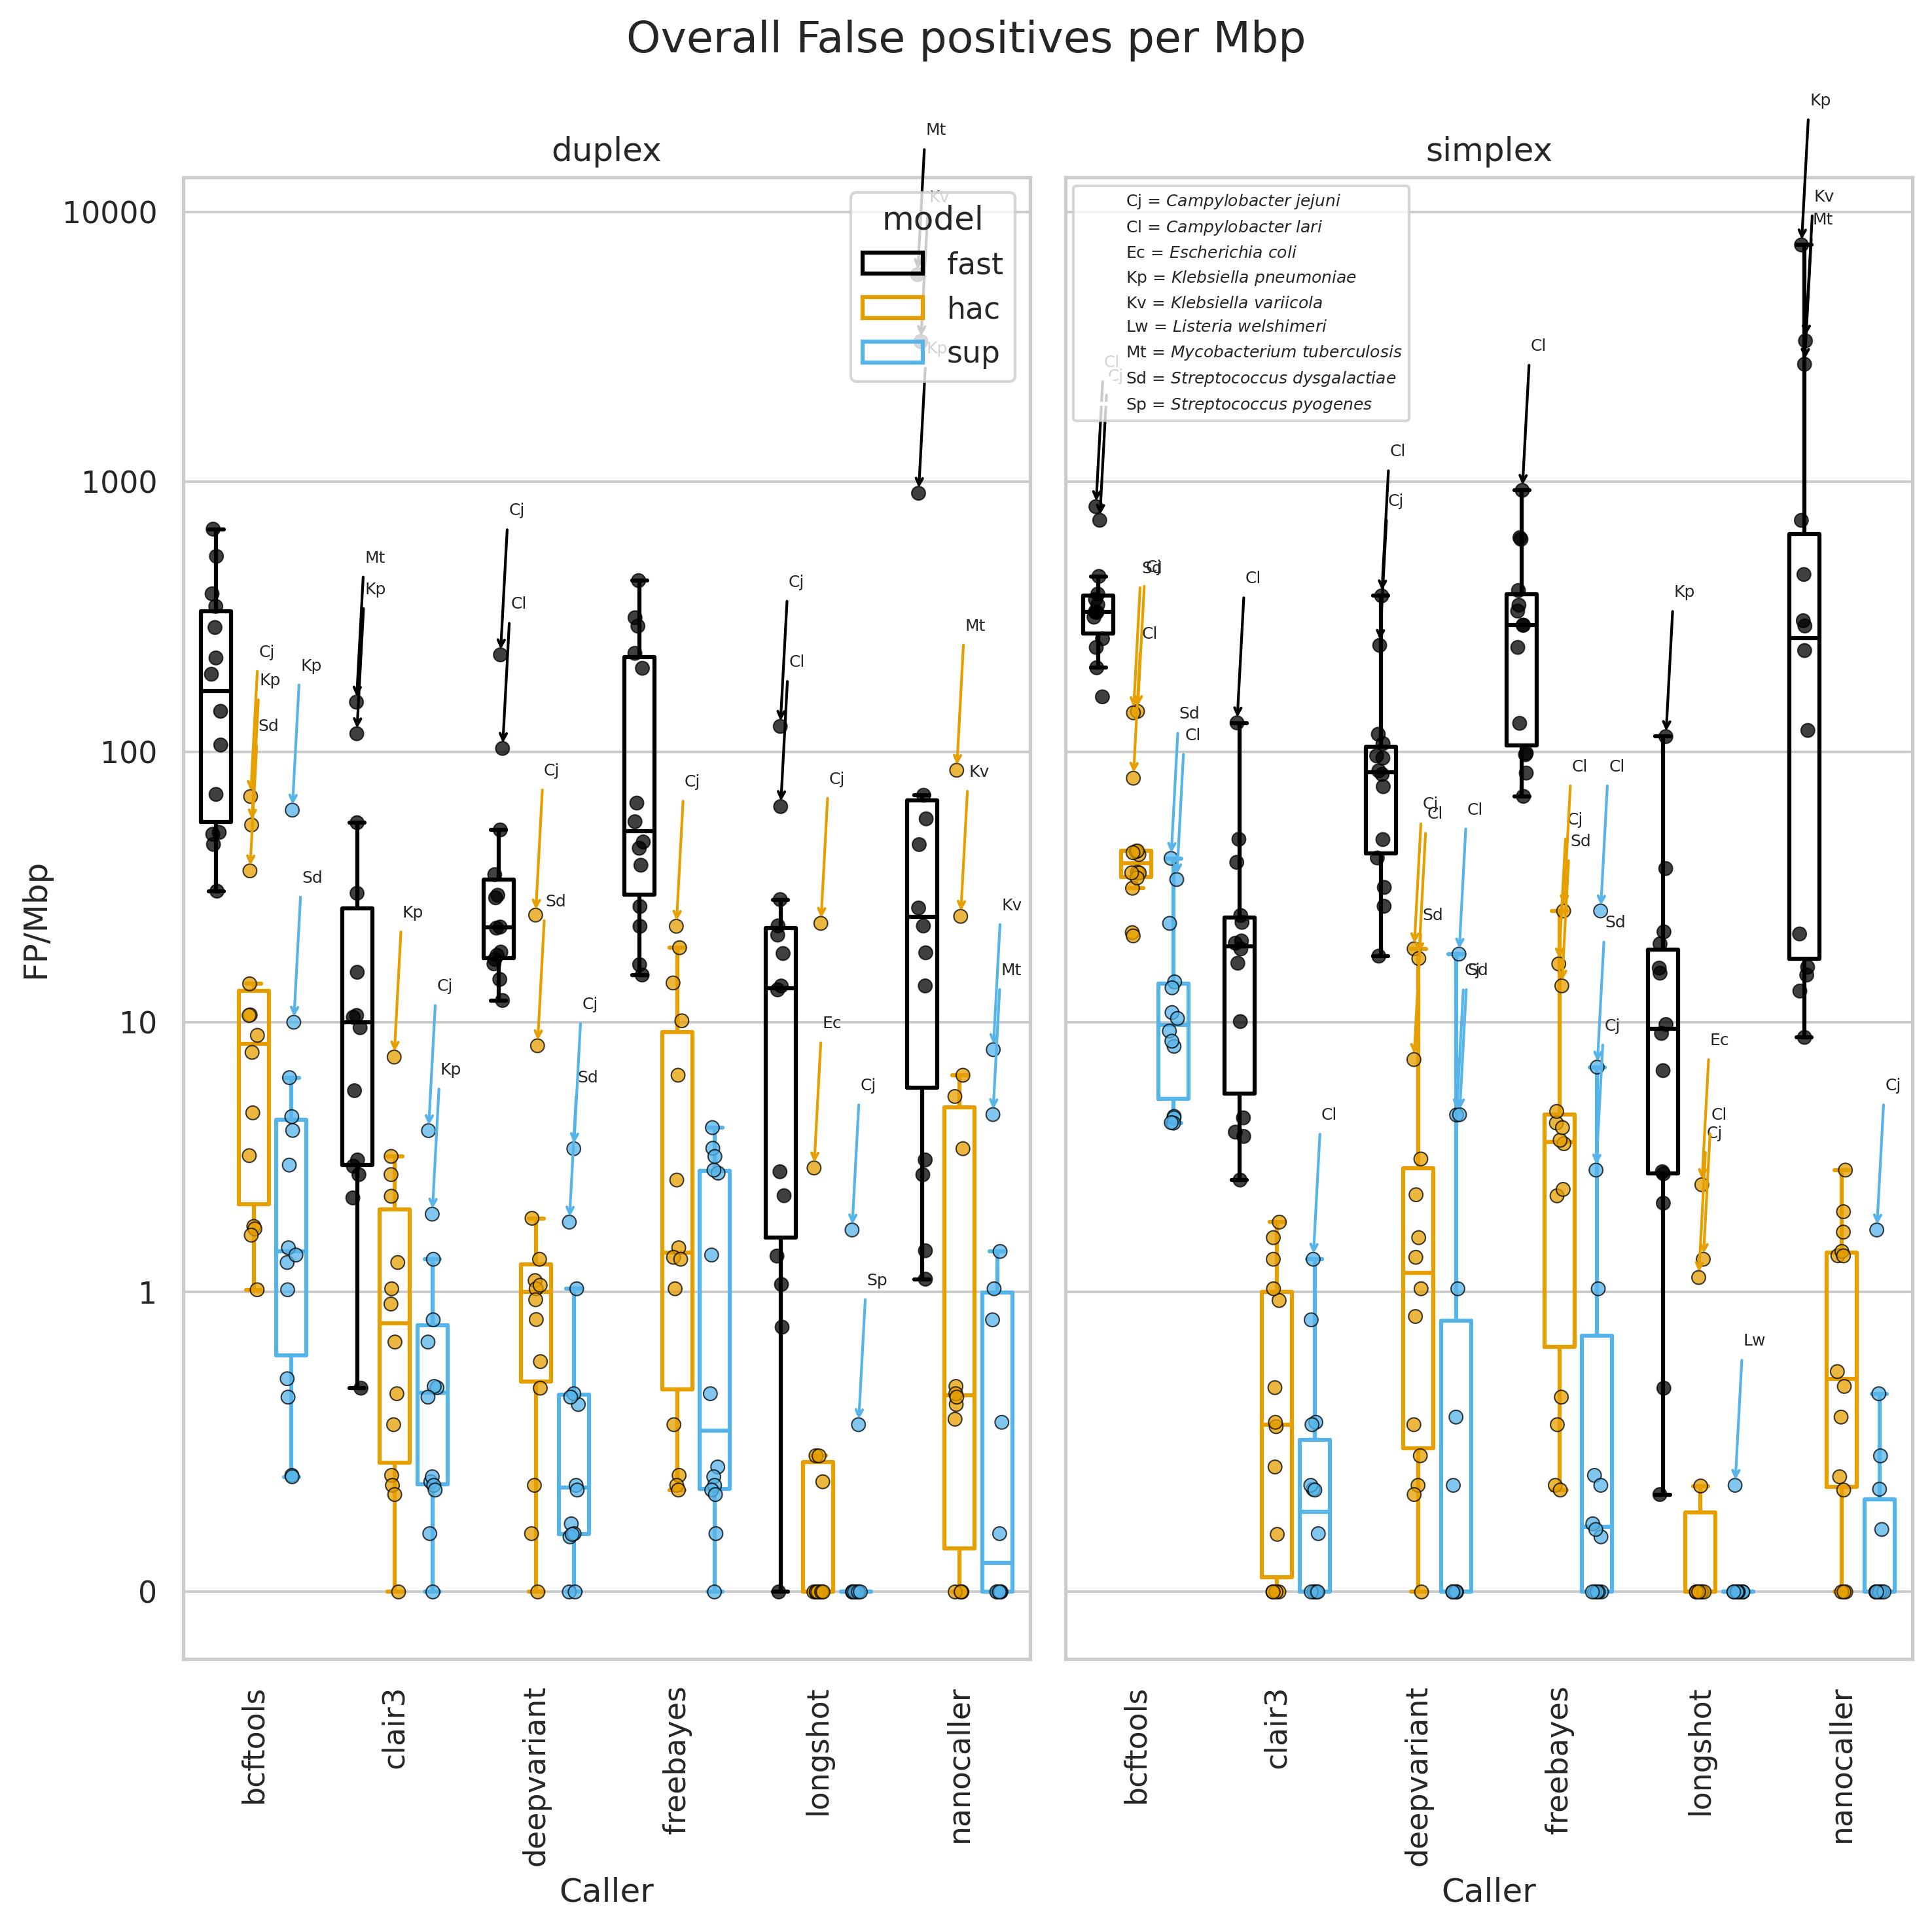

In [9]:
overall_fig, overall_axes = plot_fpr(df, "FP/Mbp", "Overall False positives per Mbp")

## Plotting SNP FPR

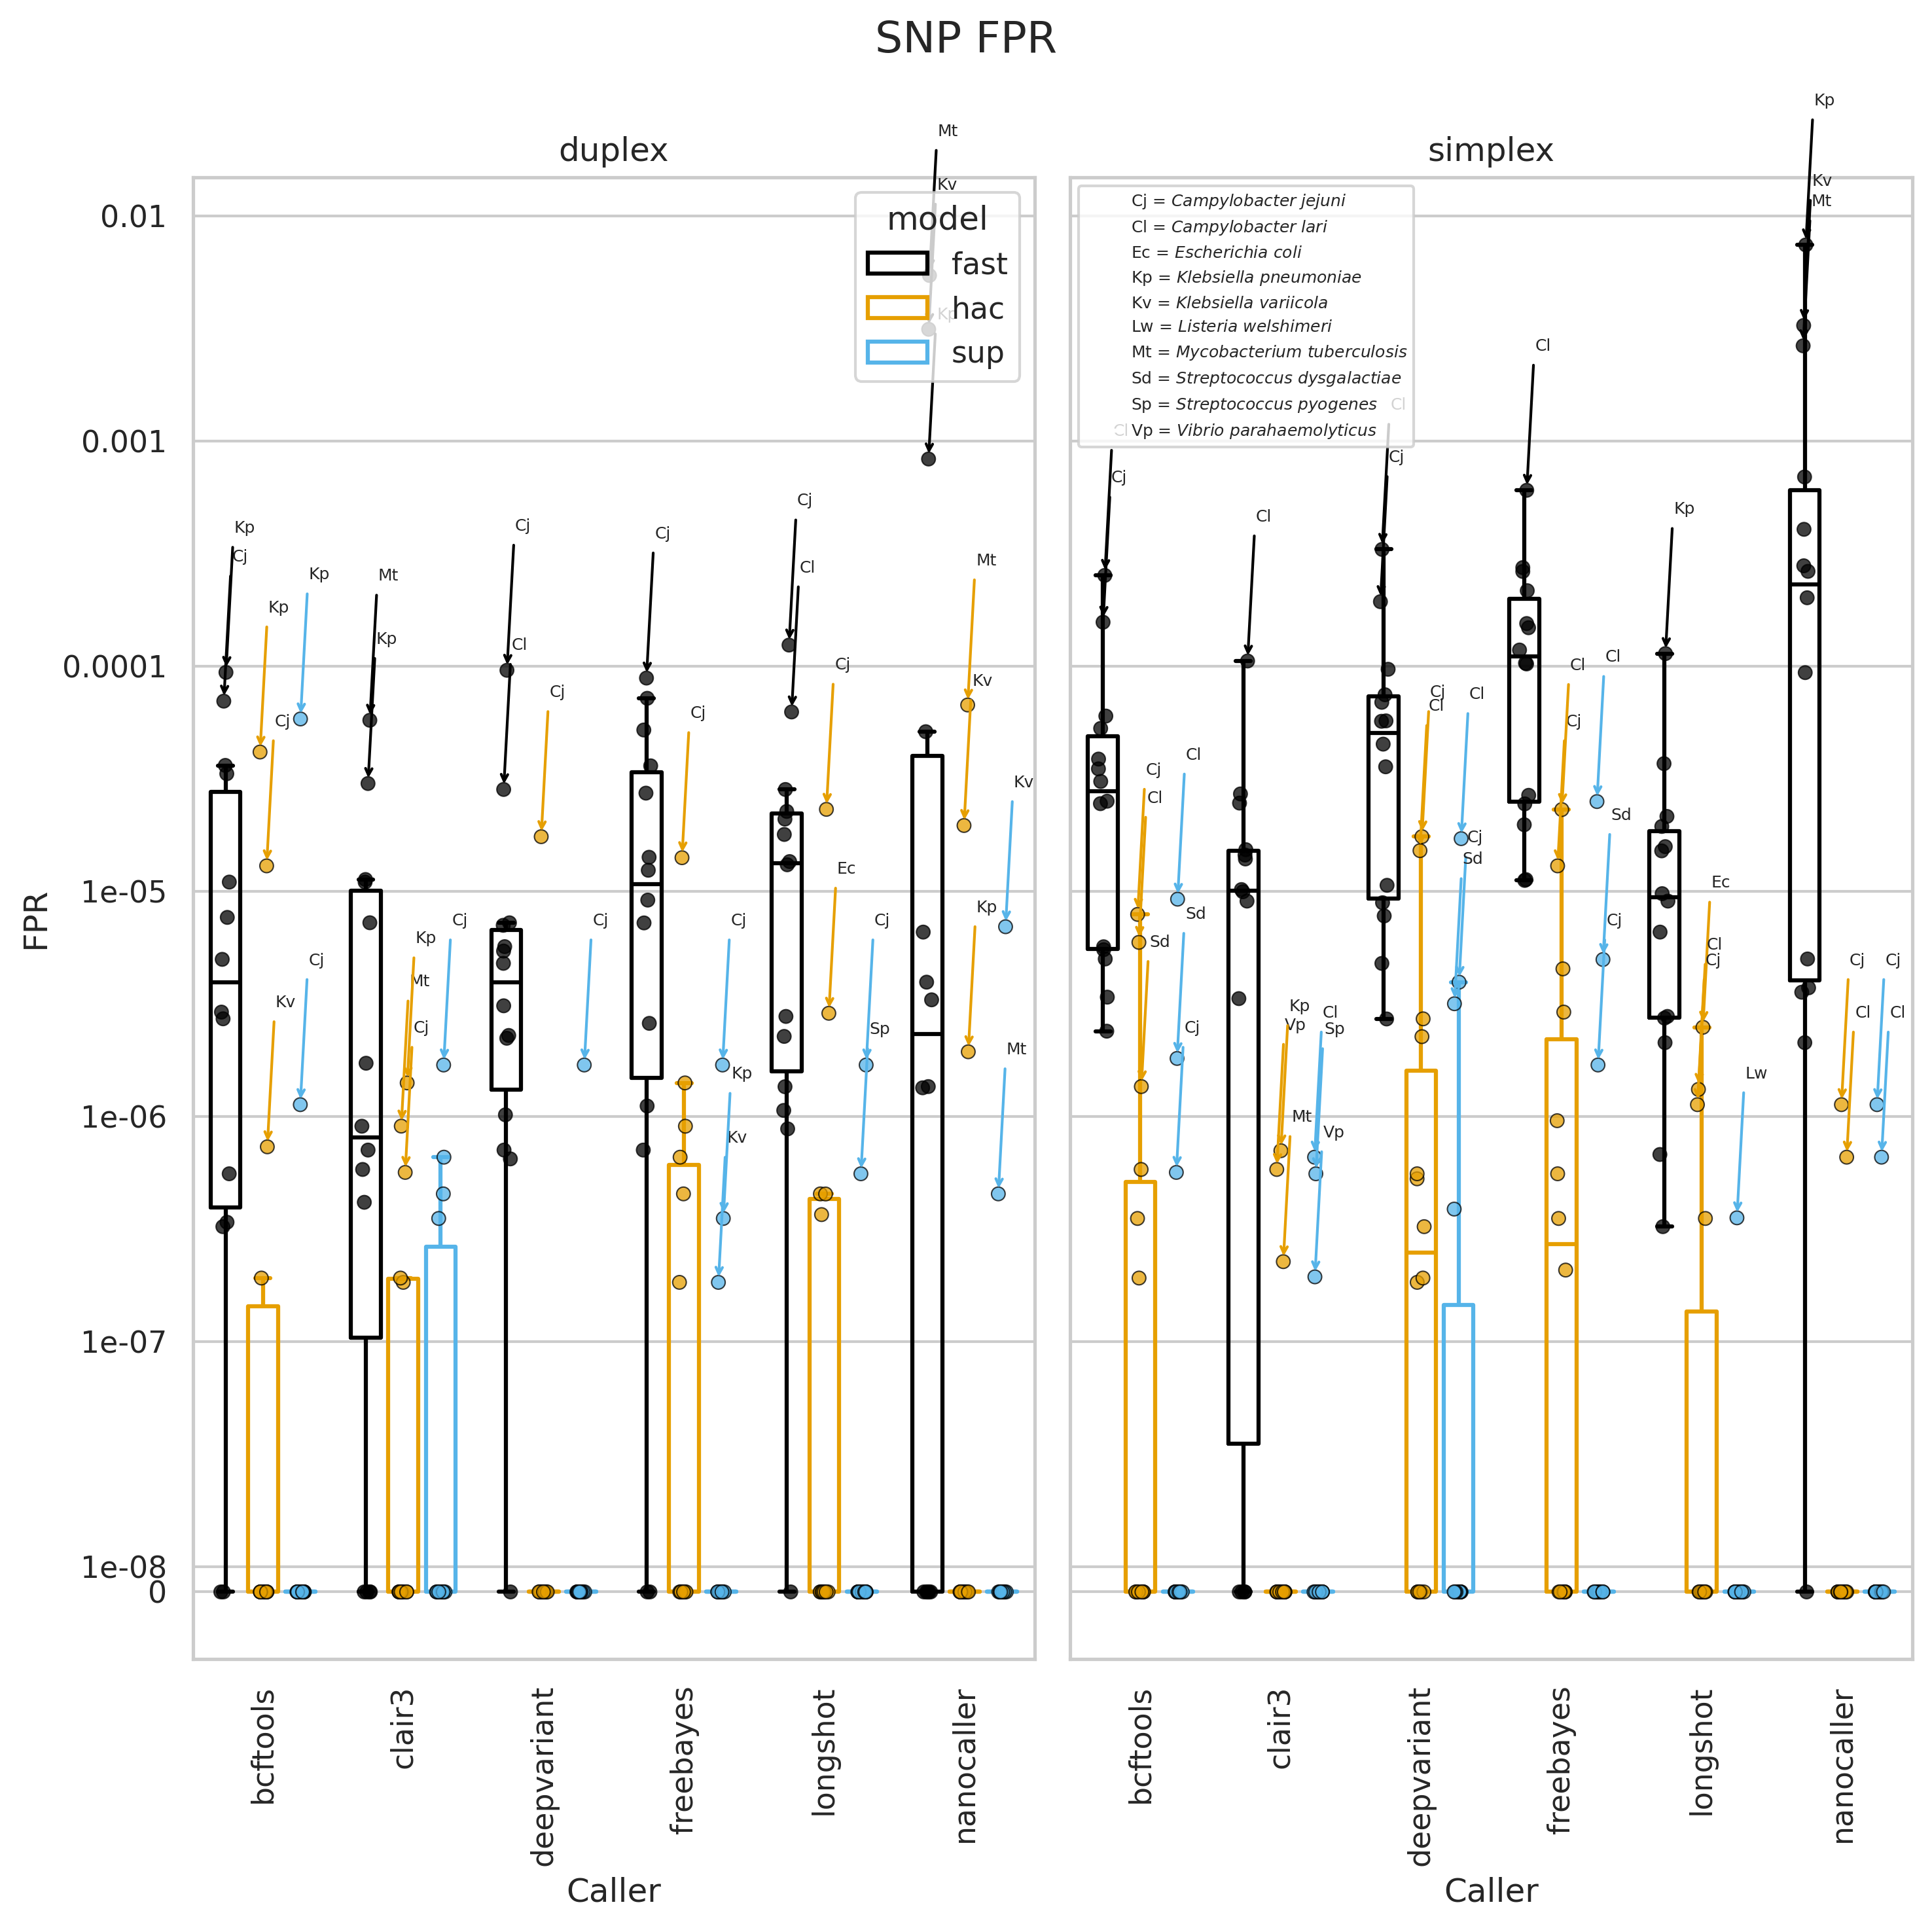

In [10]:
snp_fig, snp_axes = plot_fpr(df, "SNP_FPR", "SNP FPR")

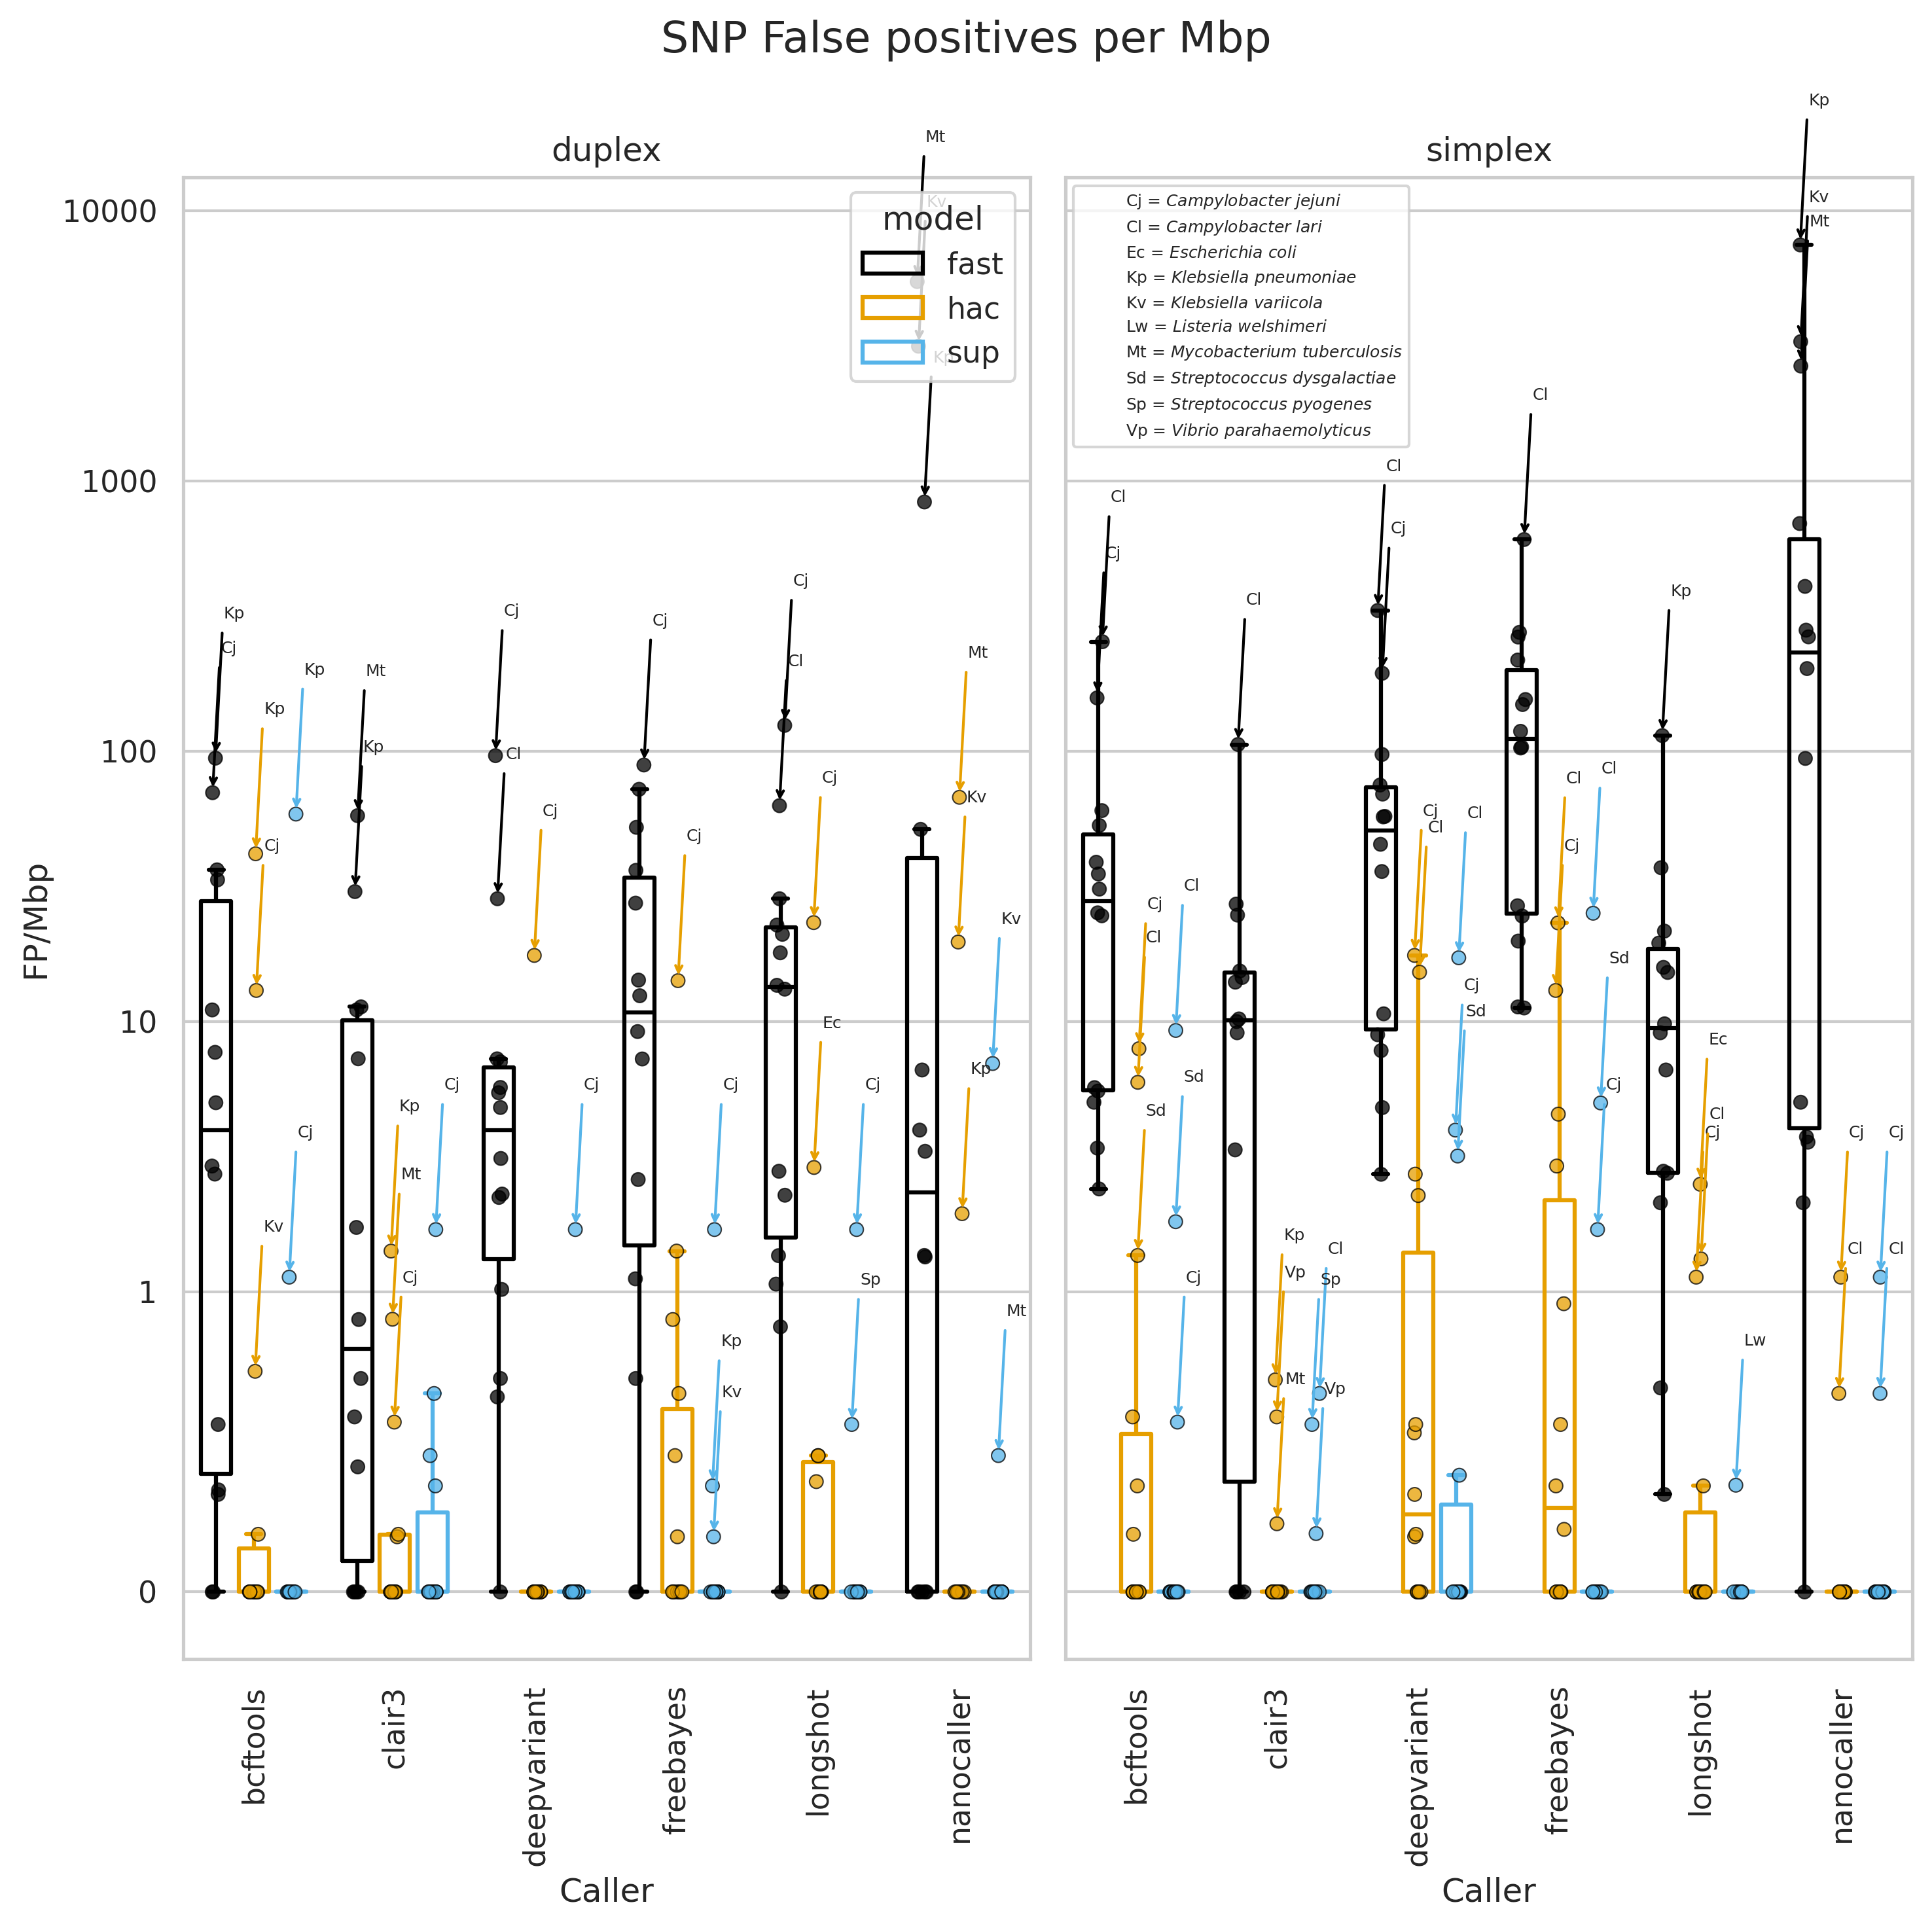

In [11]:
snp_fig, snp_axes = plot_fpr(df, "SNP_FP/Mbp", "SNP False positives per Mbp")

## Plot INDEL FPR

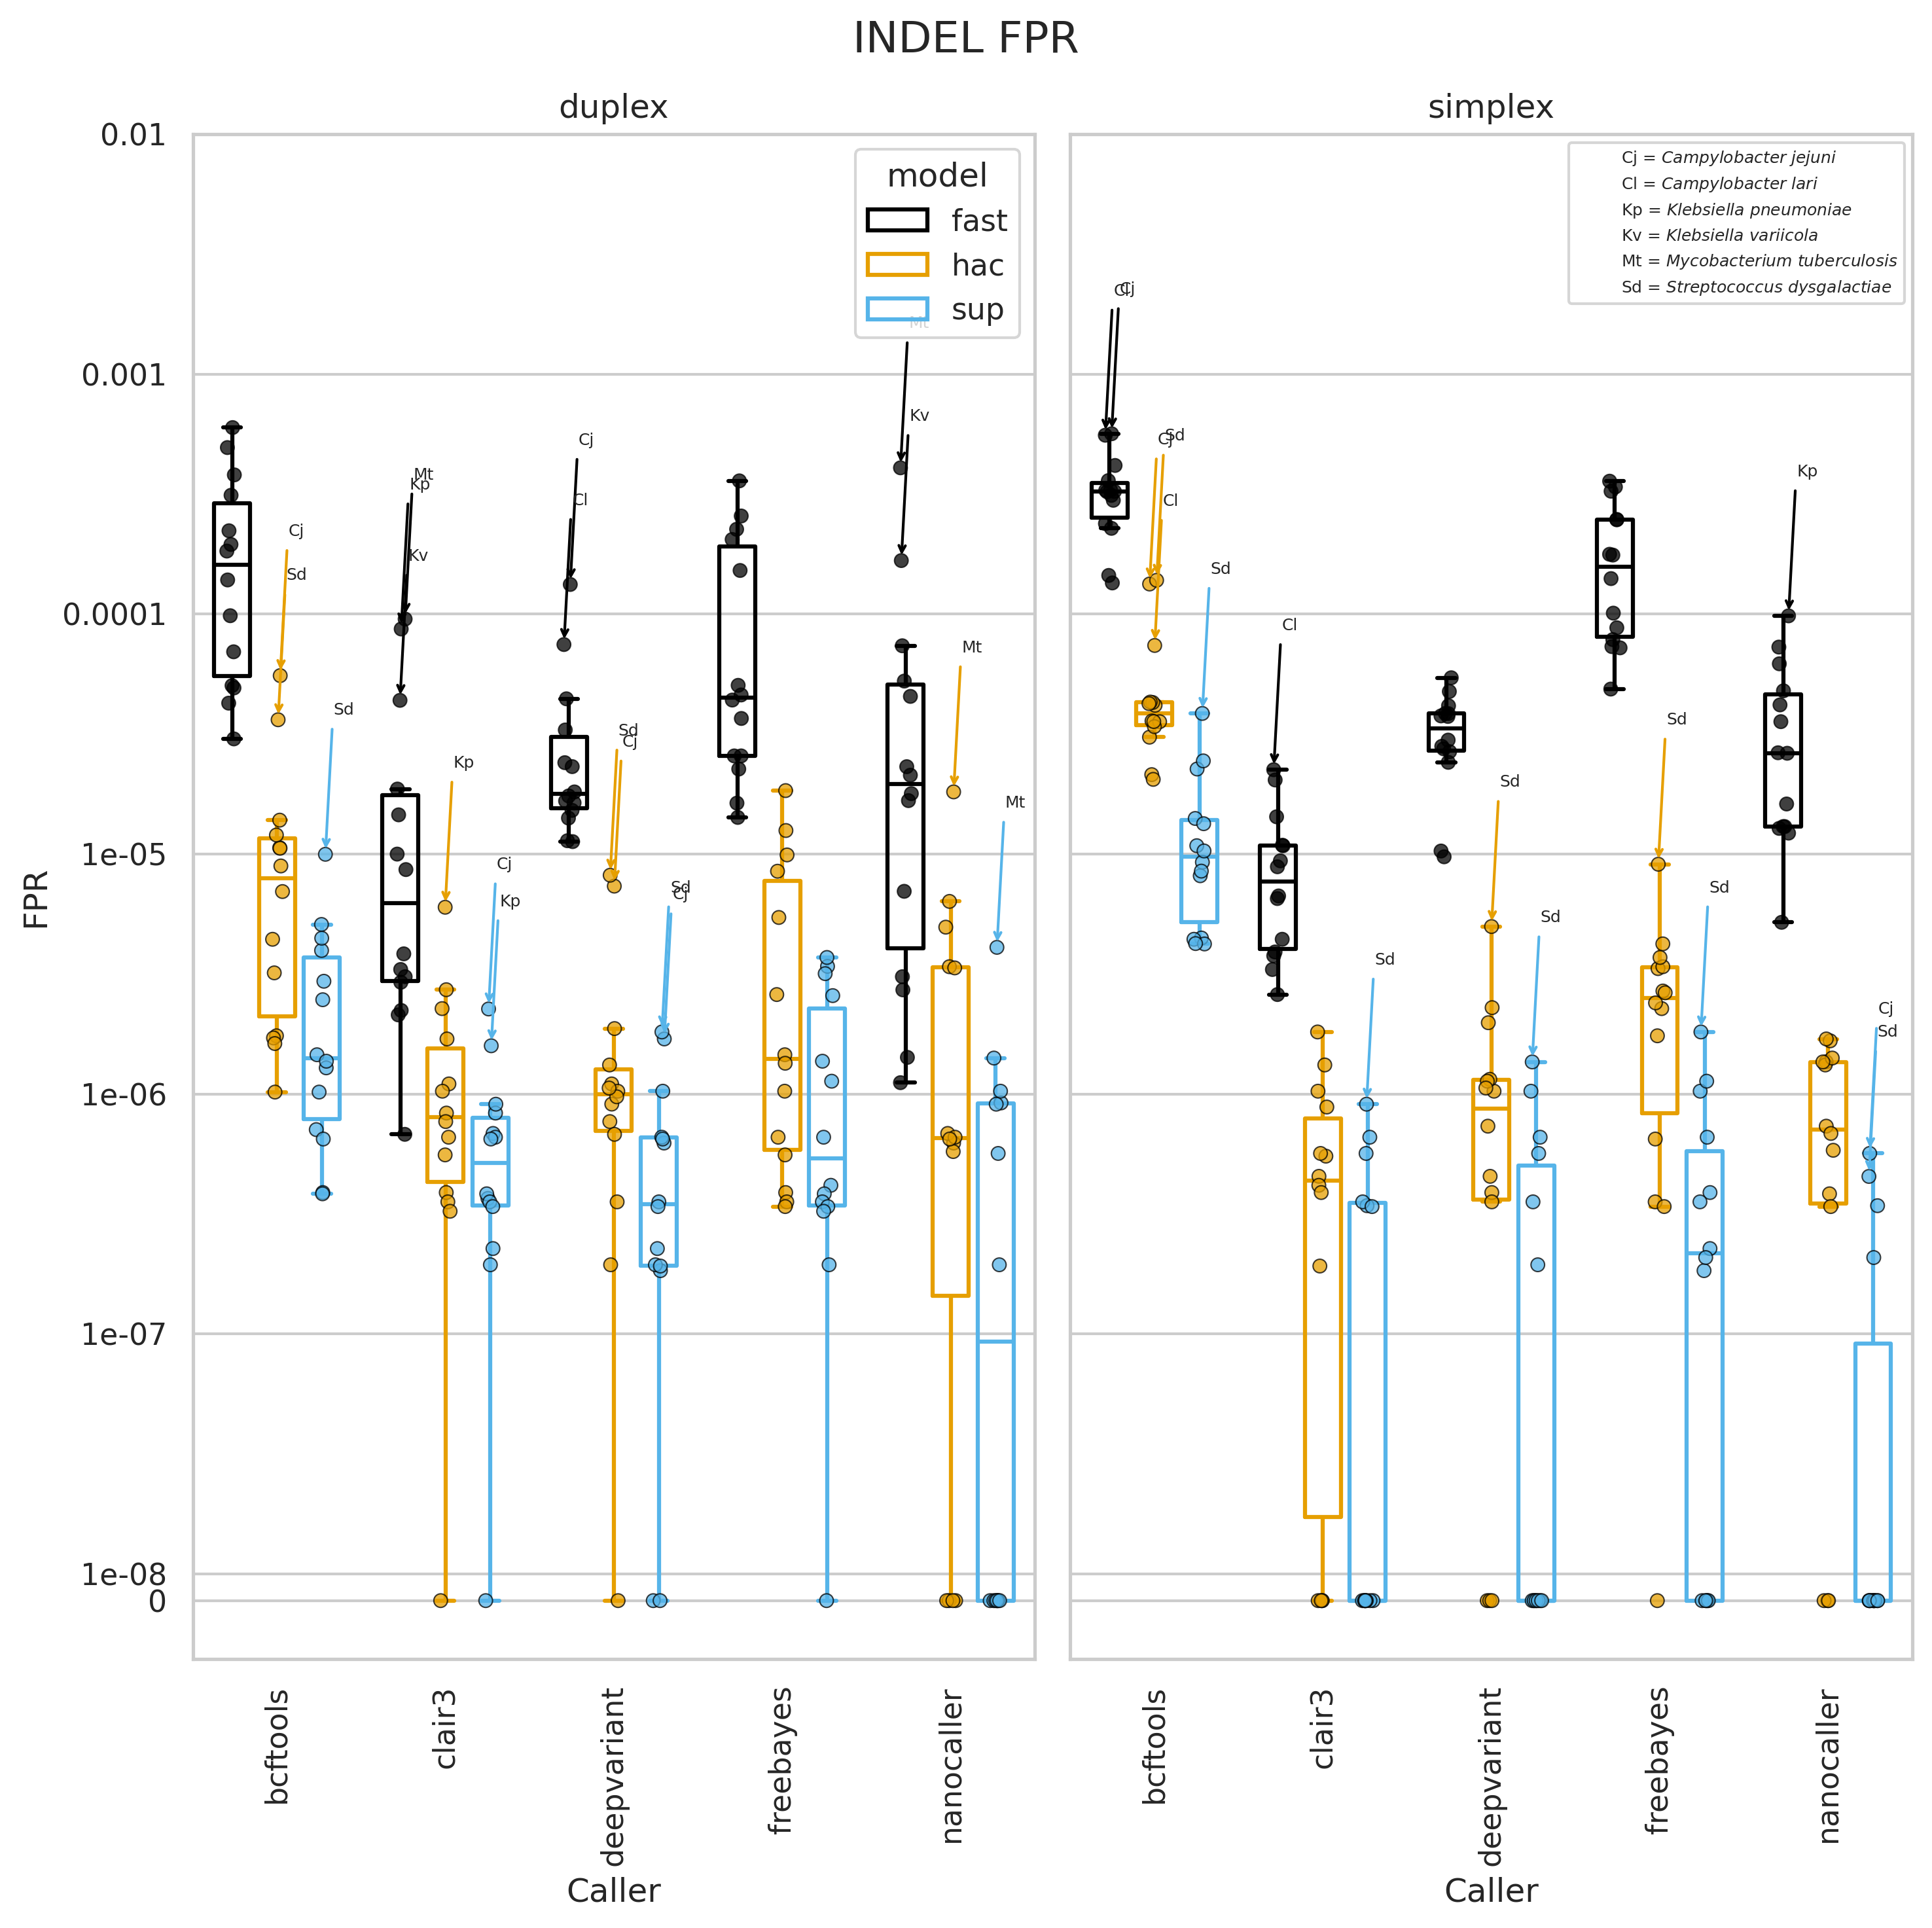

In [12]:
no_indels = ["longshot"]
data = df.query(f"caller not in {no_indels}")
indel_fig, indel_axes = plot_fpr(data, "INDEL_FPR", "INDEL FPR")

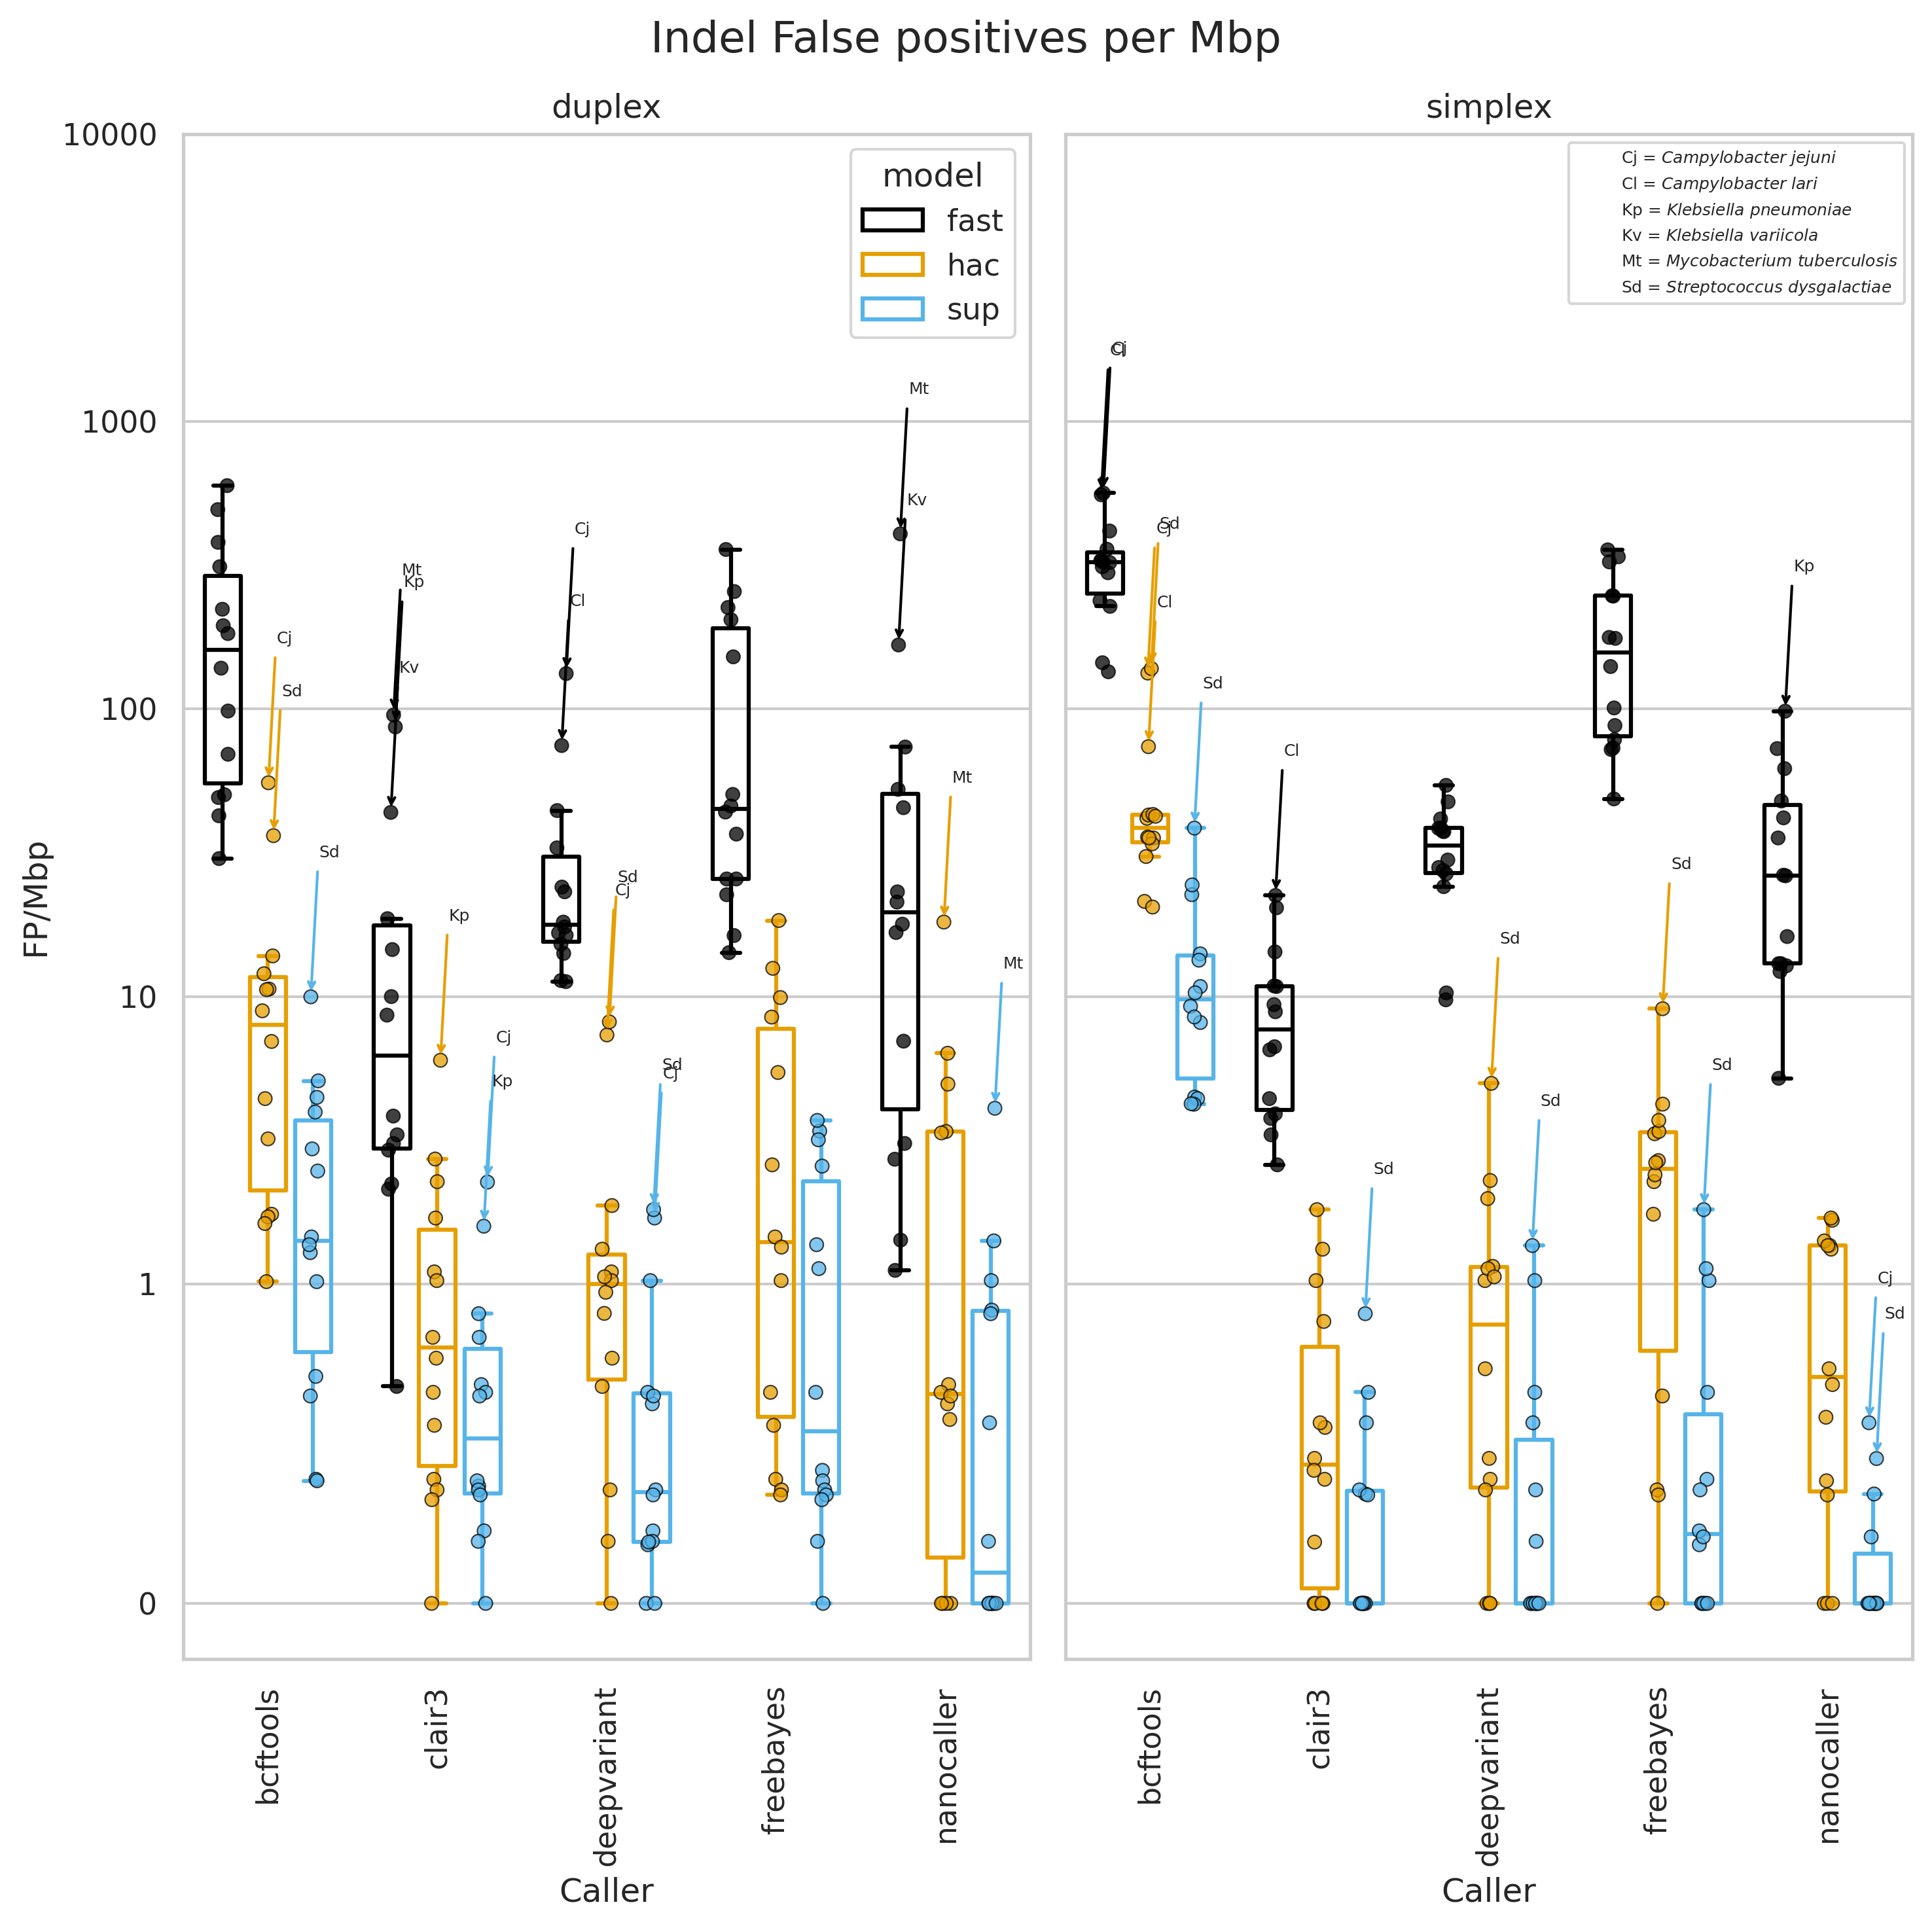

In [13]:
indel_fig, indel_axes = plot_fpr(data, "INDEL_FP/Mbp", "Indel False positives per Mbp")

In [14]:
import json
import numpy as np
from itertools import product

In [15]:
illumina_fpr = pd.read_csv("../results/assess/self/self_calls_illumina.csv")
illumina_fpr

SNP  INS  DEL  INDEL  FP   SNP_TN  INDEL_TN       TN  SNP_FPR  INDEL_FPR  \
0     0    0    0      0   0  4801704   4801704  4801704      0.0        0.0   
1     0    0    0      0   0  5147091   5147091  5147091      0.0        0.0   
2     0    0    0      0   0  5209985   5209985  5209985      0.0        0.0   
3     0    0    0      0   0  1768448   1768448  1768448      0.0        0.0   
4     0    0    0      0   0  1513368   1513368  1513368      0.0        0.0   
5     0    0    0      0   0  2919549   2919549  2919549      0.0        0.0   
6     0    0    0      0   0  2814137   2814137  2814137      0.0        0.0   
7     0    0    0      0   0  2944530   2944530  2944530      0.0        0.0   
8     0    0    0      0   0  3079933   3079933  3079933      0.0        0.0   
9     0    0    0      0   0  5445132   5445132  5445132      0.0        0.0   
10    0    0    0      0   0  5664404   5664404  5664404      0.0        0.0   
11    0    0    0      0   0  1793507   1793507  1793507      0.0        0.0   
12    0    0    0      0   0  2204985   2204985  2204985      0.0        0.0   
13    0    0    0      0   0  4405449   4405449  4405449      0.0        0.0   

    ...  3bp_hom_del 4bp_hom_del 5+bp_hom_del hom_del 2bp_hom_ins 3bp_hom_ins  \
0   ...            0           0            0       0           0           0   
1   ...            0           0            0       0           0           0   
2   ...            0           0            0       0           0           0   
3   ...            0           0            0       0           0           0   
4   ...            0           0            0       0           0           0   
5   ...            0           0            0       0           0           0   
6   ...            0           0            0       0           0           0   
7   ...            0           0            0       0           0           0   
8   ...            0           0            0       0           0           0   
9   ...            0           0            0       0           0           0   
10  ...            0           0            0       0           0           0   
11  ...            0           0            0       0           0           0   
12  ...            0           0            0       0           0           0   
13  ...            0           0            0       0           0           0   

   4bp_hom_ins  5+bp_hom_ins  hom_ins  hom_indels  
0            0             0        0           0  
1            0             0        0           0  
2            0             0        0           0  
3            0             0        0           0  
4            0             0        0           0  
5            0             0        0           0  
6            0             0        0           0  
7            0             0        0           0  
8            0             0        0           0  
9            0             0        0           0  
10           0             0        0           0  
11           0             0        0           0  
12           0             0        0           0  
13           0             0        0           0  

[14 rows x 28 columns]

In [16]:
with open("../results/assess/self/self_calls.json", "r") as f:
    full_data = json.load(f)

In [17]:
fulldf = pd.DataFrame(full_data)

In [18]:
alphabet = "ACGT"
trans_table = np.zeros((4,4), dtype=int)
for row in full_data:
    subst_types = row["substition_types"]
    for trans, count in subst_types.items():
        ref = trans[0]
        alt = trans[-1]
        i = alphabet.index(ref)
        j = alphabet.index(alt)
        # add count to table
        trans_table[i,j] += count

trans_table

array([[    0, 34162,  9358,  1100],
       [ 1012,     0,  3684, 19408],
       [14913, 15545,     0,  1573],
       [  491, 39841,  2726,     0]])

[Text(273.75, 0.5, 'Reference'), Text(0.5, 453.7499999999997, 'Alternate')]

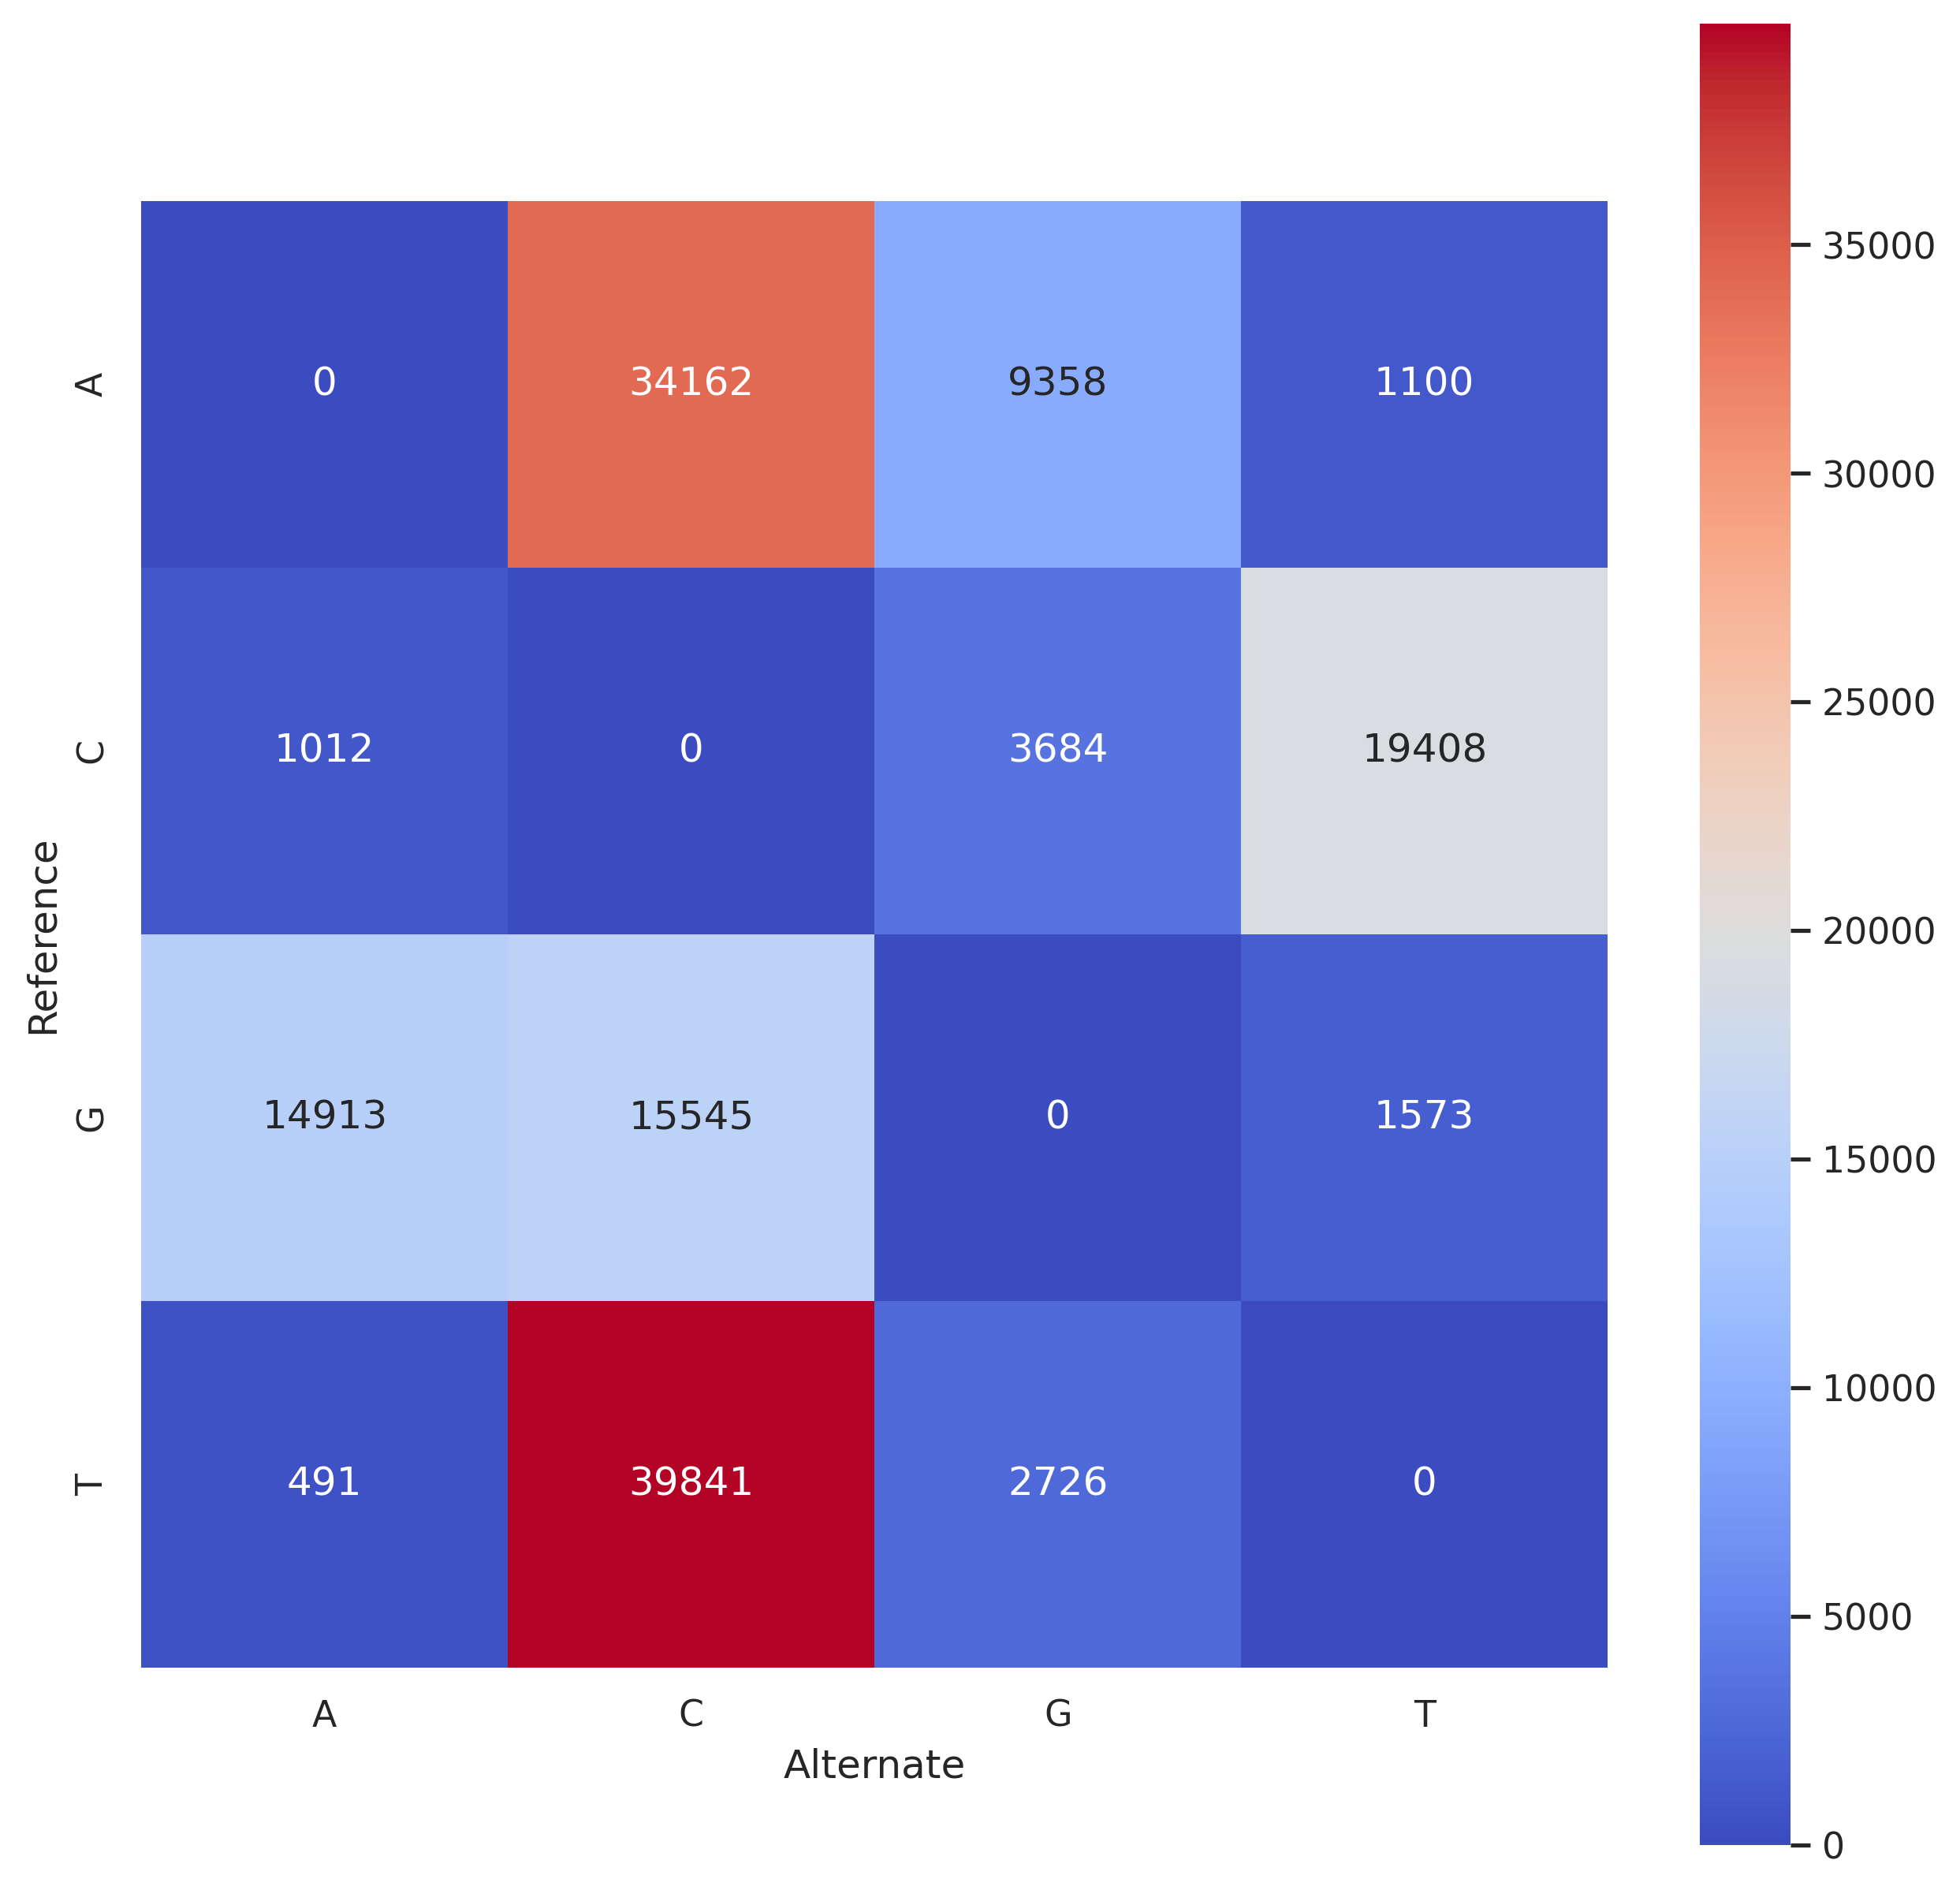

In [19]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
sns.heatmap(
    data=trans_table,
    annot=True,
    fmt="d",
    square=True,
    xticklabels=alphabet,
    yticklabels=alphabet,
    ax=ax,
    cmap="coolwarm",
)
ax.set(ylabel="Reference", xlabel="Alternate")

In [20]:
# list of all base substitutions - e.g. A>T
substitions = []
for ref, alt in product(alphabet, repeat=2):
    substitions.append(f"{ref}>{alt}")
substitions = sorted(substitions)

samples = {d["sample"] for d in full_data}
n_samples = len(samples)
samples = sorted(list(samples))

model_substitutions = dict()
for d in full_data:
    mode = d["mode"]
    model = d["model"]
    sample = d["sample"]
    j = samples.index(sample)
    substition_types = d["substition_types"]
    if mode not in model_substitutions:
        model_substitutions[mode] = dict()
    if model not in model_substitutions[mode]:
        model_substitutions[mode][model] = np.zeros((len(substitions), n_samples), dtype=int)
    for subst, count in substition_types.items():
        i = substitions.index(subst)
        model_substitutions[mode][model][i,j] += count


In [21]:
model_substitutions

{'duplex': {'dna_r10.4.1_e8.2_400bps_fast@v4.3.0': array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0],
         [3652, 5620,    1,    4,    0,    0,    0,    0,    0,    0,   19,
           621,    0,    1],
         [1130, 1576,    3,    2,    0,   15,    7,   10,    0,    1,   13,
           704,    0,    0],
         [ 265,  424,    0,    0,    0,    0,    5,    2,    0,    0,    1,
           106,    0,    0],
         [ 136,  274,    0,    2,    0,    1,    2,    1,    0,    0,    1,
           132,    0,    0],
         [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0],
         [ 609, 1112,    1,    1,    0,    3,   12,    3,    4,    2,    4,
           397,    0,    0],
         [2359, 2807,  100,   97,    0,  134,  324,  127,    5,    0,   17,
           705,   34,    3],
         [1311, 1508,  101,  107,    0,  133,  323,  121,    0,    0,   18,
           723,   28,    1],
      

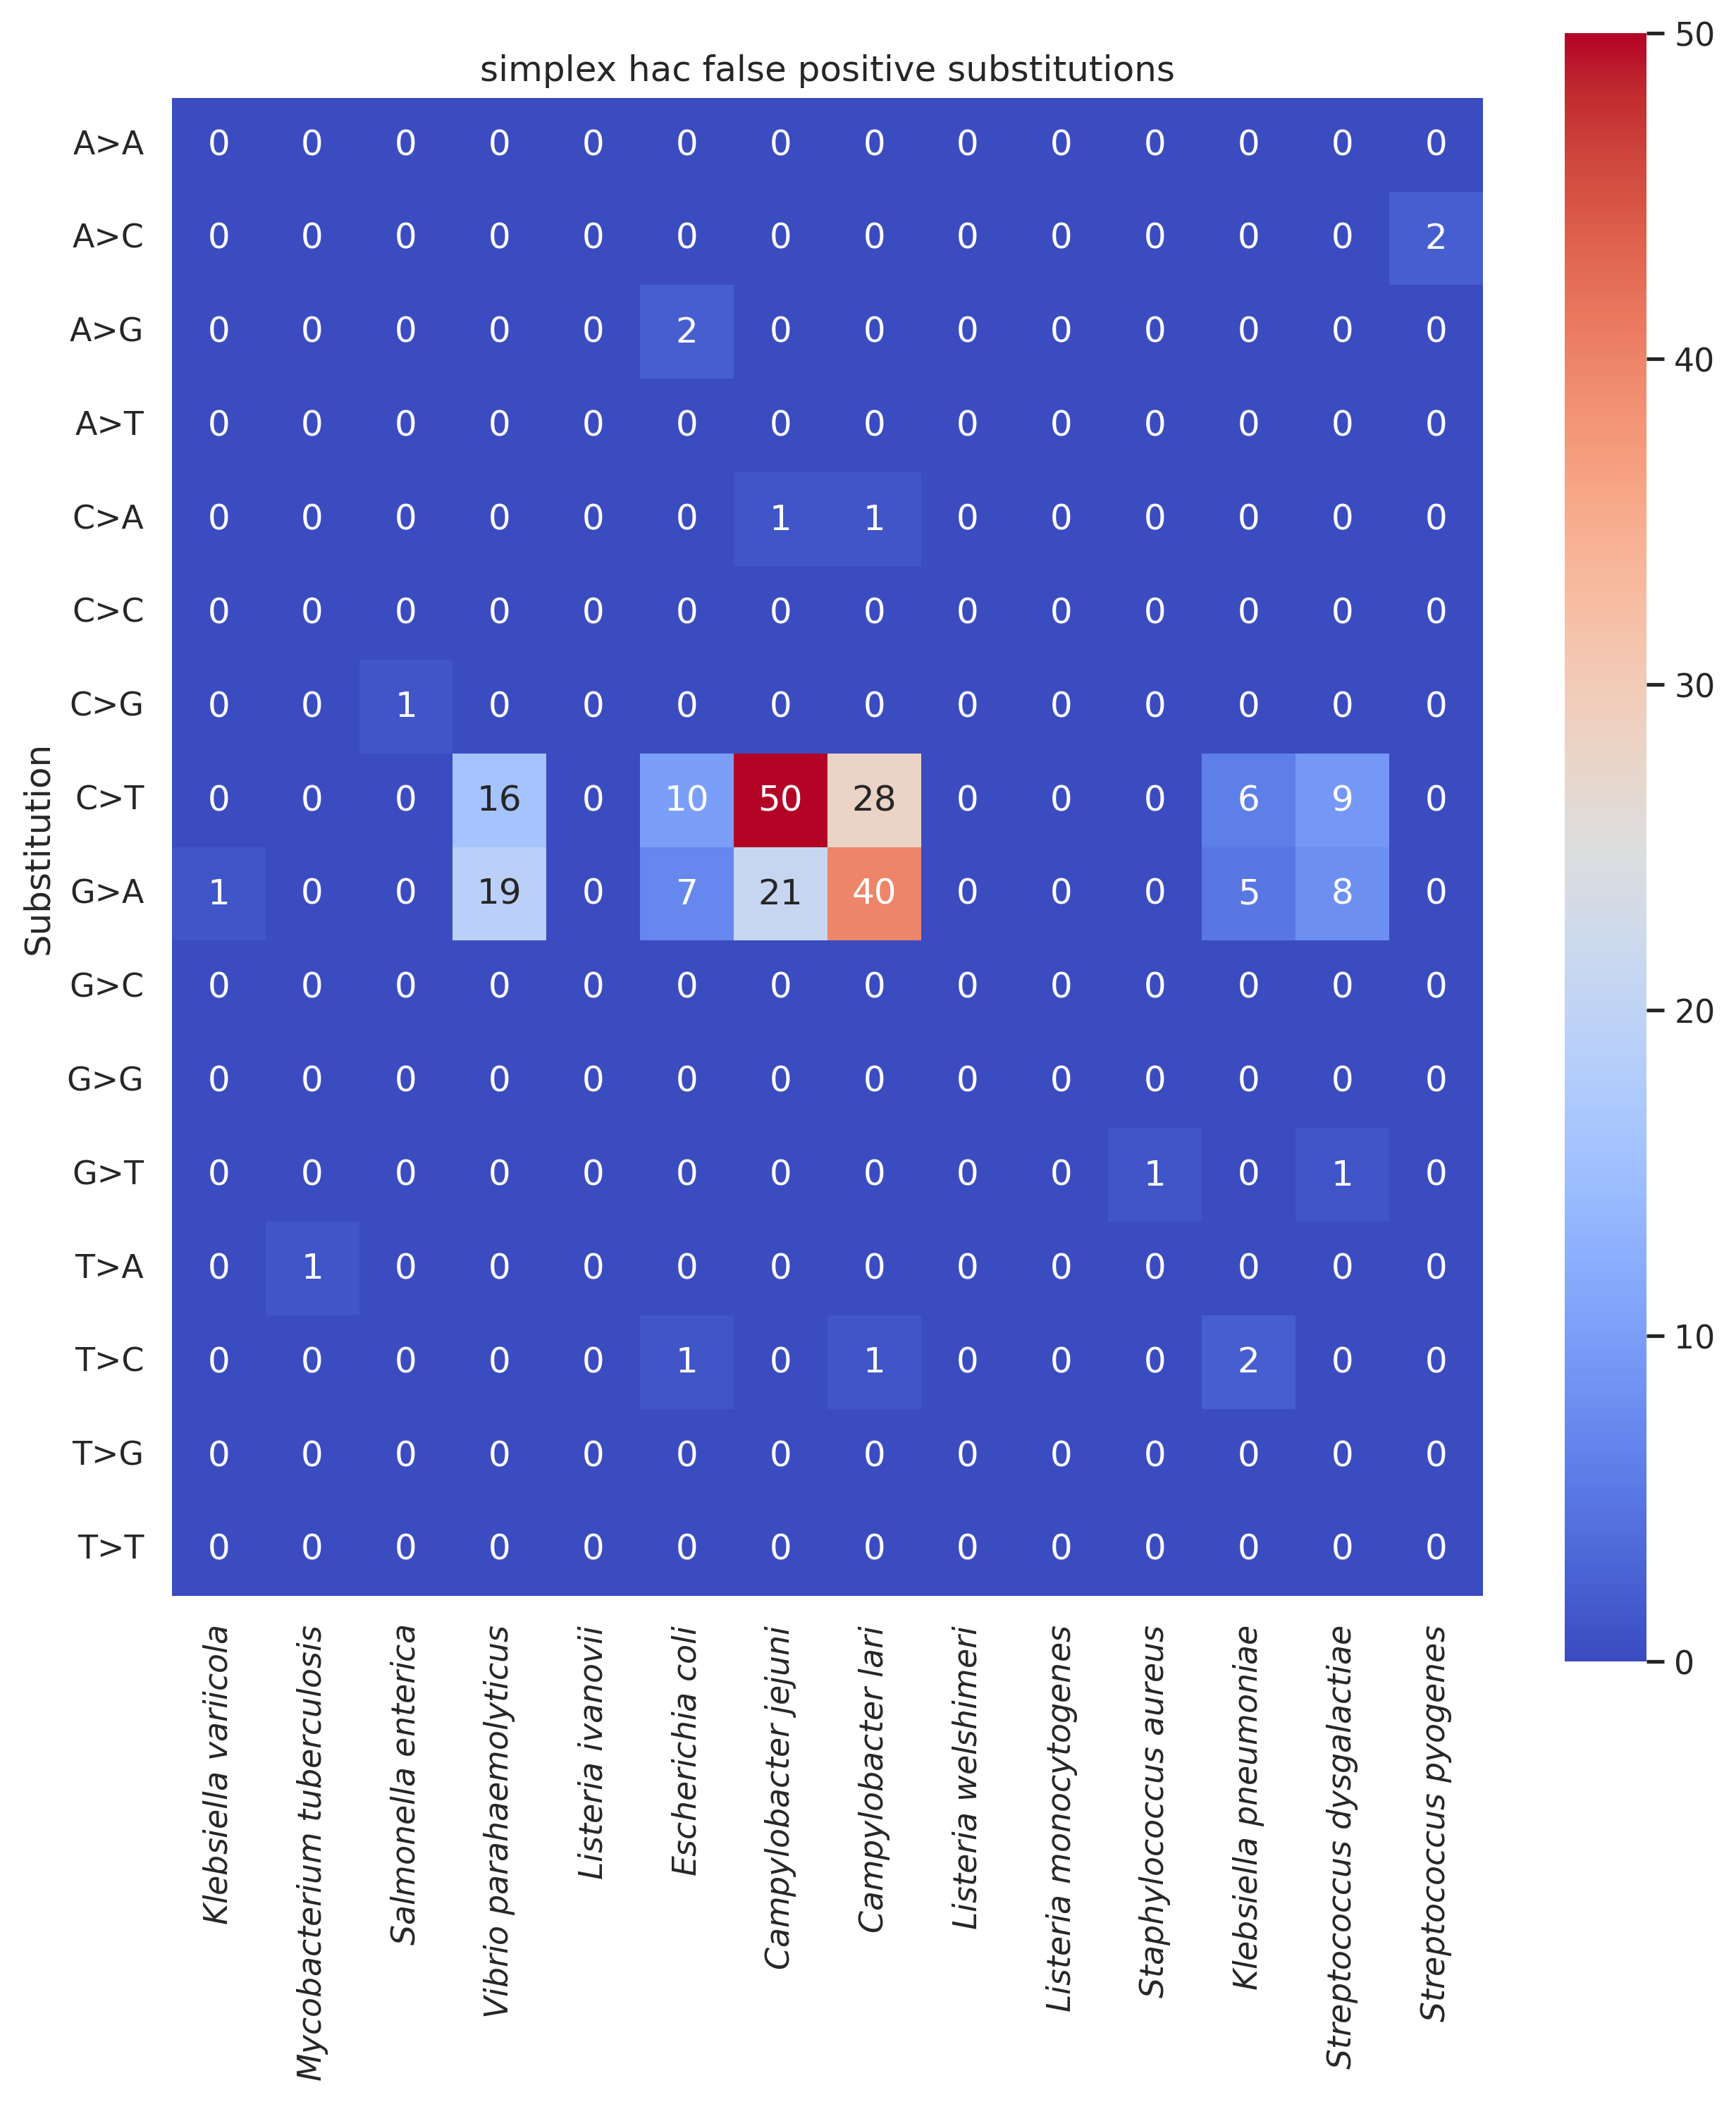

In [22]:
mode = "simplex"
model = "hac"
data = model_substitutions[mode][f"dna_r10.4.1_e8.2_400bps_{model}@v4.3.0"]
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
xticklabels = [
    samplesheet["species"].loc[sample] for sample in samples
]
# make the xticklabels italic
xticklabels = [f"$\it{{{s.split('_')[0]}}}$ $\it{{{s.split('_')[1]}}}$" for s in xticklabels]
sns.heatmap(
    data=data,
    annot=True,
    fmt="d",
    square=True,
    xticklabels=xticklabels,
    yticklabels=substitions,
    ax=ax,
    cmap="coolwarm",
)
ax.set(ylabel="Substitution", title=f"{mode} {model} false positive substitutions")
# rotate yticklabels
for tick in ax.get_yticklabels():
    tick.set_rotation(0)

In [23]:
fulldf.head()

2bp_hom_del  2bp_hom_ins  3bp_hom_del  3bp_hom_ins  4bp_hom_del  \
0     0.090106     0.002381     0.035336     0.000794     0.012367   
1     0.125786     0.000000     0.044025     0.000000     0.012579   
2     0.069409     0.072581     0.033419     0.000000     0.002571   
3     0.044527     0.011538     0.007421     0.000000     0.003711   
4     0.053012     0.006006     0.016867     0.000000     0.007229   

   4bp_hom_ins  5+bp_hom_del  5+bp_hom_ins  DEL    FP  ...   hom_del  \
0          0.0      0.003534           0.0  566  1850  ...  0.950530   
1          0.0      0.006289           0.0  159   234  ...  0.943396   
2          0.0      0.000000           0.0  389   553  ...  0.979434   
3          0.0      0.000000           0.0  539  1183  ...  0.931354   
4          0.0      0.000000           0.0  415   803  ...  0.934940   

   hom_indels   hom_ins                              homopolymer_deletions  \
0    0.983571  0.998413  {'1': 458, '2': 51, '3': 20, '4': 7, '5': 1, '...   
1    0.945205  0.950000        {'1': 120, '2': 20, '3': 7, '4': 2, '5': 1}   
2    0.968811  0.935484               {'1': 340, '2': 27, '3': 13, '4': 1}   
3    0.958451  0.986538                {'1': 472, '2': 24, '3': 4, '4': 2}   
4    0.953209  0.975976                {'1': 356, '2': 22, '3': 7, '4': 3}   

        homopolymer_insertions    mode                                model  \
0  {'1': 1254, '2': 3, '3': 1}  duplex  dna_r10.4.1_e8.2_400bps_fast@v4.3.0   
1                    {'1': 57}  duplex  dna_r10.4.1_e8.2_400bps_fast@v4.3.0   
2           {'1': 107, '2': 9}  duplex  dna_r10.4.1_e8.2_400bps_fast@v4.3.0   
3           {'1': 507, '2': 6}  duplex  dna_r10.4.1_e8.2_400bps_fast@v4.3.0   
4           {'1': 323, '2': 2}  duplex  dna_r10.4.1_e8.2_400bps_fast@v4.3.0   

               sample                                   substition_types  \
0  ATCC_10708__202309                             {'C>T': 14, 'G>A': 10}   
1  ATCC_17802__202309                               {'C>T': 9, 'G>A': 6}   
2  ATCC_25922__202309         {'A>G': 2, 'C>T': 16, 'G>A': 21, 'G>C': 1}   
3  ATCC_33560__202309         {'C>G': 2, 'C>T': 66, 'G>A': 54, 'G>C': 2}   
4  ATCC_35221__202309  {'A>G': 1, 'C>T': 27, 'G>A': 24, 'G>C': 1, 'T>...   

  version  
0  v4.3.0  
1  v4.3.0  
2  v4.3.0  
3  v4.3.0  
4  v4.3.0  

[5 rows x 31 columns]

In [24]:
indel_df = fulldf.melt(
    id_vars=["sample", "mode", "model", "depth", "caller", "version"],
    value_vars=[
        "2bp_hom_del",
        "2bp_hom_ins",
        "3bp_hom_del",
        "3bp_hom_ins",
        "4bp_hom_del",
        "4bp_hom_ins",
        "5+bp_hom_del",
        "5+bp_hom_ins",
    ],
    var_name="indel_type",
    value_name="proportion",
)
indel_df.query("caller not in @no_indels and mode == 'simplex'", inplace=True)

/tmp/ipykernel_279730/2702543396.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del_df["proportion"] = -del_df["proportion"]
/tmp/ipykernel_279730/2702543396.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del_df["indel_type"] = del_df["indel_type"].str.replace("_hom_del", "")
/tmp/ipykernel_279730/2702543396.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/tmp/ipykernel_279730/2702543396.py:44: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.stripplot(
/tmp/ipykernel_279730/2702543396.py:56: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.pointplot(
/tmp/ipykernel_279730/2702543396.py:61: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.pointplot(
/tmp/ipykernel_279730/2702543396.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del_df["proportion"] = -del_df["proportion"]
/tmp/ipykernel_279730/2702543396.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Text(0.5, 0.98, 'Proportion of indels which are homopolymers')

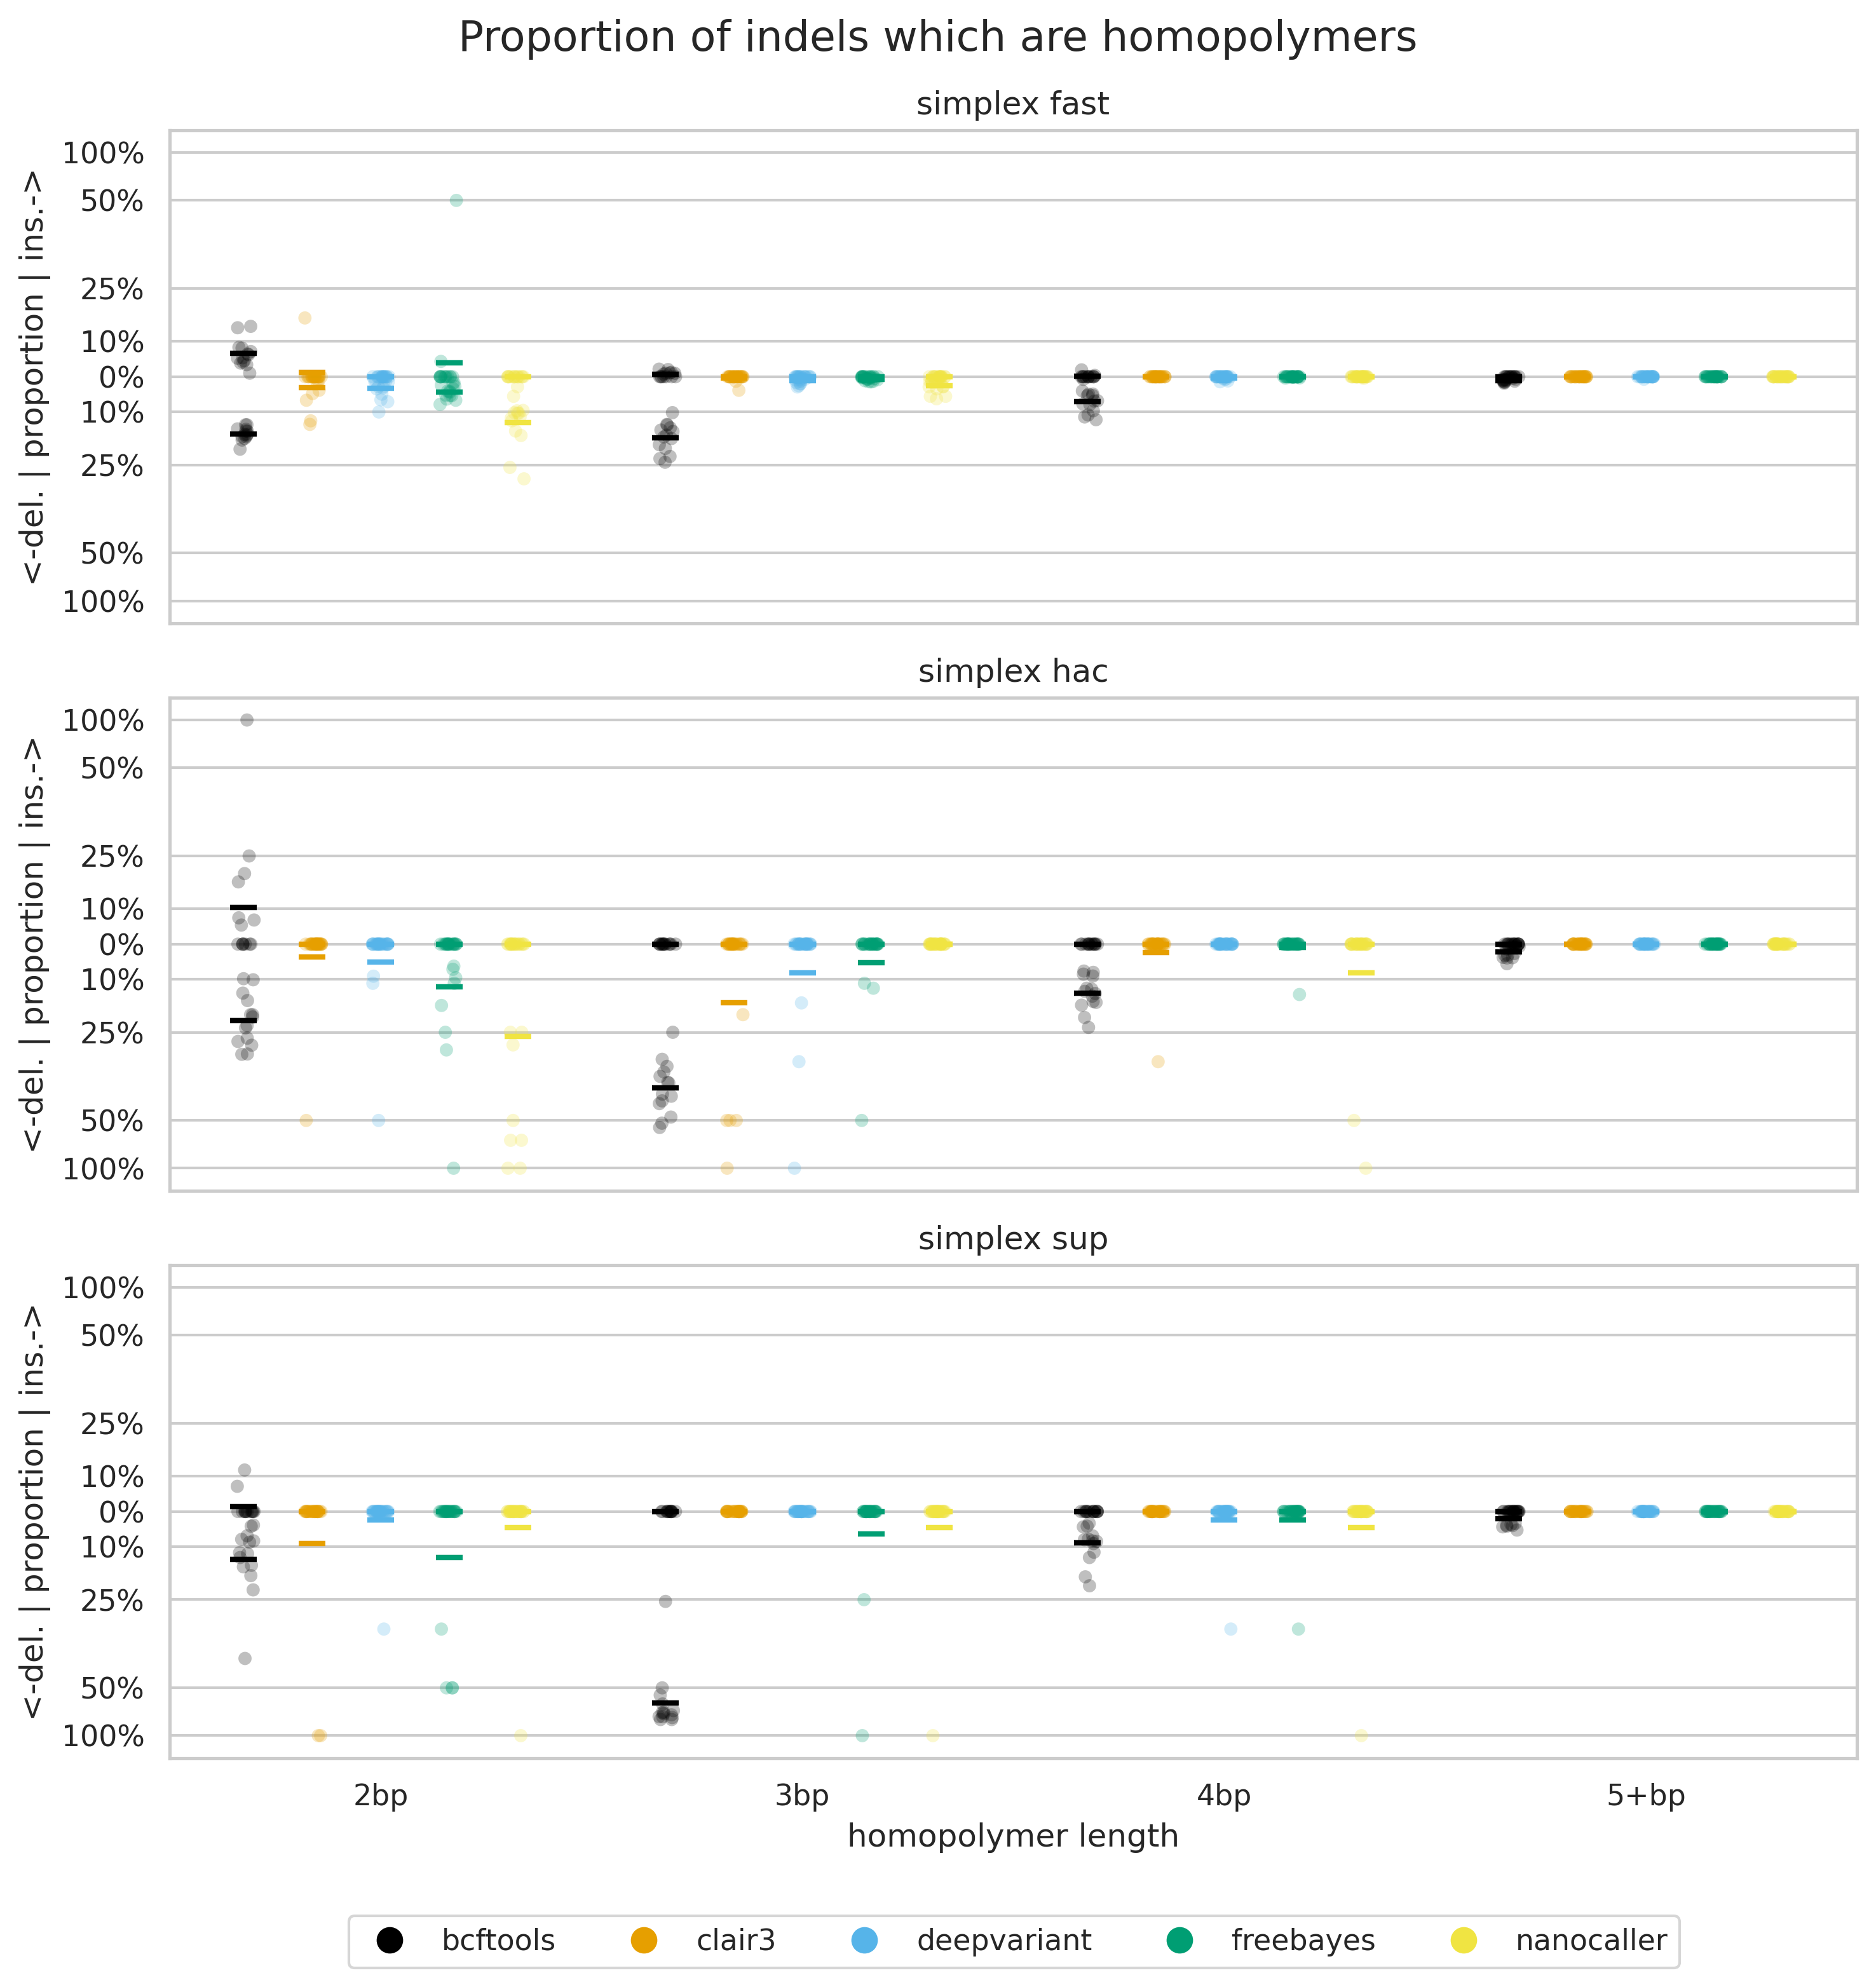

In [25]:
row = "model"
col = "mode"
hue = "caller"
palette = cud(start=0)
fig, axes = plt.subplots(
    figsize=(10, 10),
    dpi=300,
    nrows=len(indel_df[row].unique()),
    ncols=len(indel_df[col].unique()),
    sharey=True,
    sharex=True,
    tight_layout=True,
    squeeze=False,
)
legend_drawn = False
indel_df["model"] = indel_df["model"].apply(lambda x: x.split("_")[-1].split("@")[0])

for i, model in enumerate(indel_df[row].unique()):
    model_df = indel_df.query(f"{row} == '{model}'")
    for j, mode in enumerate(model_df[col].unique()):
        mode_df = model_df.query(f"{col} == '{mode}'")
        del_df = mode_df.query("indel_type.str.contains('del')")
        # make the del_df proportions negative
        del_df["proportion"] = -del_df["proportion"]
        # remove the "del" from the indel_type
        del_df["indel_type"] = del_df["indel_type"].str.replace("_hom_del", "")
        ins_df = mode_df.query("indel_type.str.contains('ins')")
        # remove the "ins" from the indel_type
        ins_df["indel_type"] = ins_df["indel_type"].str.replace("_hom_ins", "")
        ax = axes[i, j]
        kwargs = dict(
            x="indel_type",
            y="proportion",
            hue=hue,
            palette=palette,
            ax=ax,
            dodge=0.4,
            alpha=0.25
        )
        sns.stripplot(
            data=del_df,
            **kwargs,
        )
        sns.stripplot(
            data=ins_df,
            legend=False,
            **kwargs,
        )

        del kwargs["alpha"]
        kwargs["dodge"] = 0.65
        kwargs["markersize"] = 10
        kwargs["marker"] = "_"
        kwargs["linestyle"] = "none"
        kwargs["errorbar"] = None
        sns.pointplot(
            data=del_df,
            legend=False,
            **kwargs,
        )
        sns.pointplot(
            data=ins_df,
            legend=False,
            **kwargs,
        )


        ax.set_title(f"{mode} {model}")
        ax.set_xlabel("homopolymer length")
        ax.set_ylabel("<-del. | proportion | ins.->")
        ax.set_yscale("symlog", linthresh=0.5)
        yticks = [-1.0, -0.5, -0.25, -0.1, 0, 0.1, 0.25, 0.5, 1]
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{abs(y):.0%}" for y in yticks])

        if not legend_drawn:
            lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
            lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
            for line in lines:
                line.set_alpha(1)
            fig.legend(
                lines,
                labels,
                loc="lower center",
                # title=hue,
                ncols=len(fulldf[hue].unique()),
                bbox_to_anchor=(0.54, -0.05),
                markerscale=2,
            )
            legend_drawn = True
        
        ax.get_legend().remove()

fig.suptitle("Proportion of indels which are homopolymers", fontsize=16)

# Precision Recall curves

In [26]:
from pathlib import Path

In [27]:
frames = []
for p in Path("../results/assess/mutref").rglob("*.precision-recall.tsv"):
    df = pd.read_csv(p, sep="\t")
    df["sample"] = p.parent.name
    if "illumina" in str(p):
        df["caller"] = "illumina"
        df["depth"] = "illumina"
        df["mode"] = "simplex"
        df["version"] = "illumina"
        df["model"] = "illumina"
    else:
        df["caller"] = p.parts[-7]
        df["depth"] = p.parts[-6]
        df["mode"] = p.parts[-5]
        df["version"] = p.parts[-4]
        df["model"] = p.parts[-3].split("_")[-1].split("@")[0]
    frames.append(df)

In [28]:
pr_df = pd.concat(frames)
pr_df.head()

VAR_TYPE  MIN_QUAL      PREC    RECALL  F1_SCORE  F1_QSCORE  TRUTH_TOTAL  \
0      SNP         0  0.997615  0.992412  0.995007  23.016054        21481   
1      SNP         1  0.997615  0.992412  0.995007  23.016054        21481   
2      SNP         2  0.997615  0.992412  0.995007  23.016054        21481   
3      SNP         3  0.997615  0.992412  0.995007  23.016054        21481   
4      SNP         4  0.997615  0.992412  0.995007  23.016054        21481   

   TRUTH_TP  TRUTH_FN  QUERY_TOTAL  QUERY_TP  QUERY_FP          sample  \
0     21318       163        21383     21332        51  AMtb_1__202402   
1     21318       163        21383     21332        51  AMtb_1__202402   
2     21318       163        21383     21332        51  AMtb_1__202402   
3     21318       163        21383     21332        51  AMtb_1__202402   
4     21318       163        21383     21332        51  AMtb_1__202402   

     caller     depth     mode   version     model  
0  illumina  illumina  simplex  illumina  illumina  
1  illumina  illumina  simplex  illumina  illumina  
2  illumina  illumina  simplex  illumina  illumina  
3  illumina  illumina  simplex  illumina  illumina  
4  illumina  illumina  simplex  illumina  illumina

In [29]:
set(pr_df.caller)

{'bcftools',
 'clair3',
 'deepvariant',
 'freebayes',
 'illumina',
 'longshot',
 'nanocaller'}

/tmp/ipykernel_279730/2148005211.py:4: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.lineplot(


(0.92, 1.001)

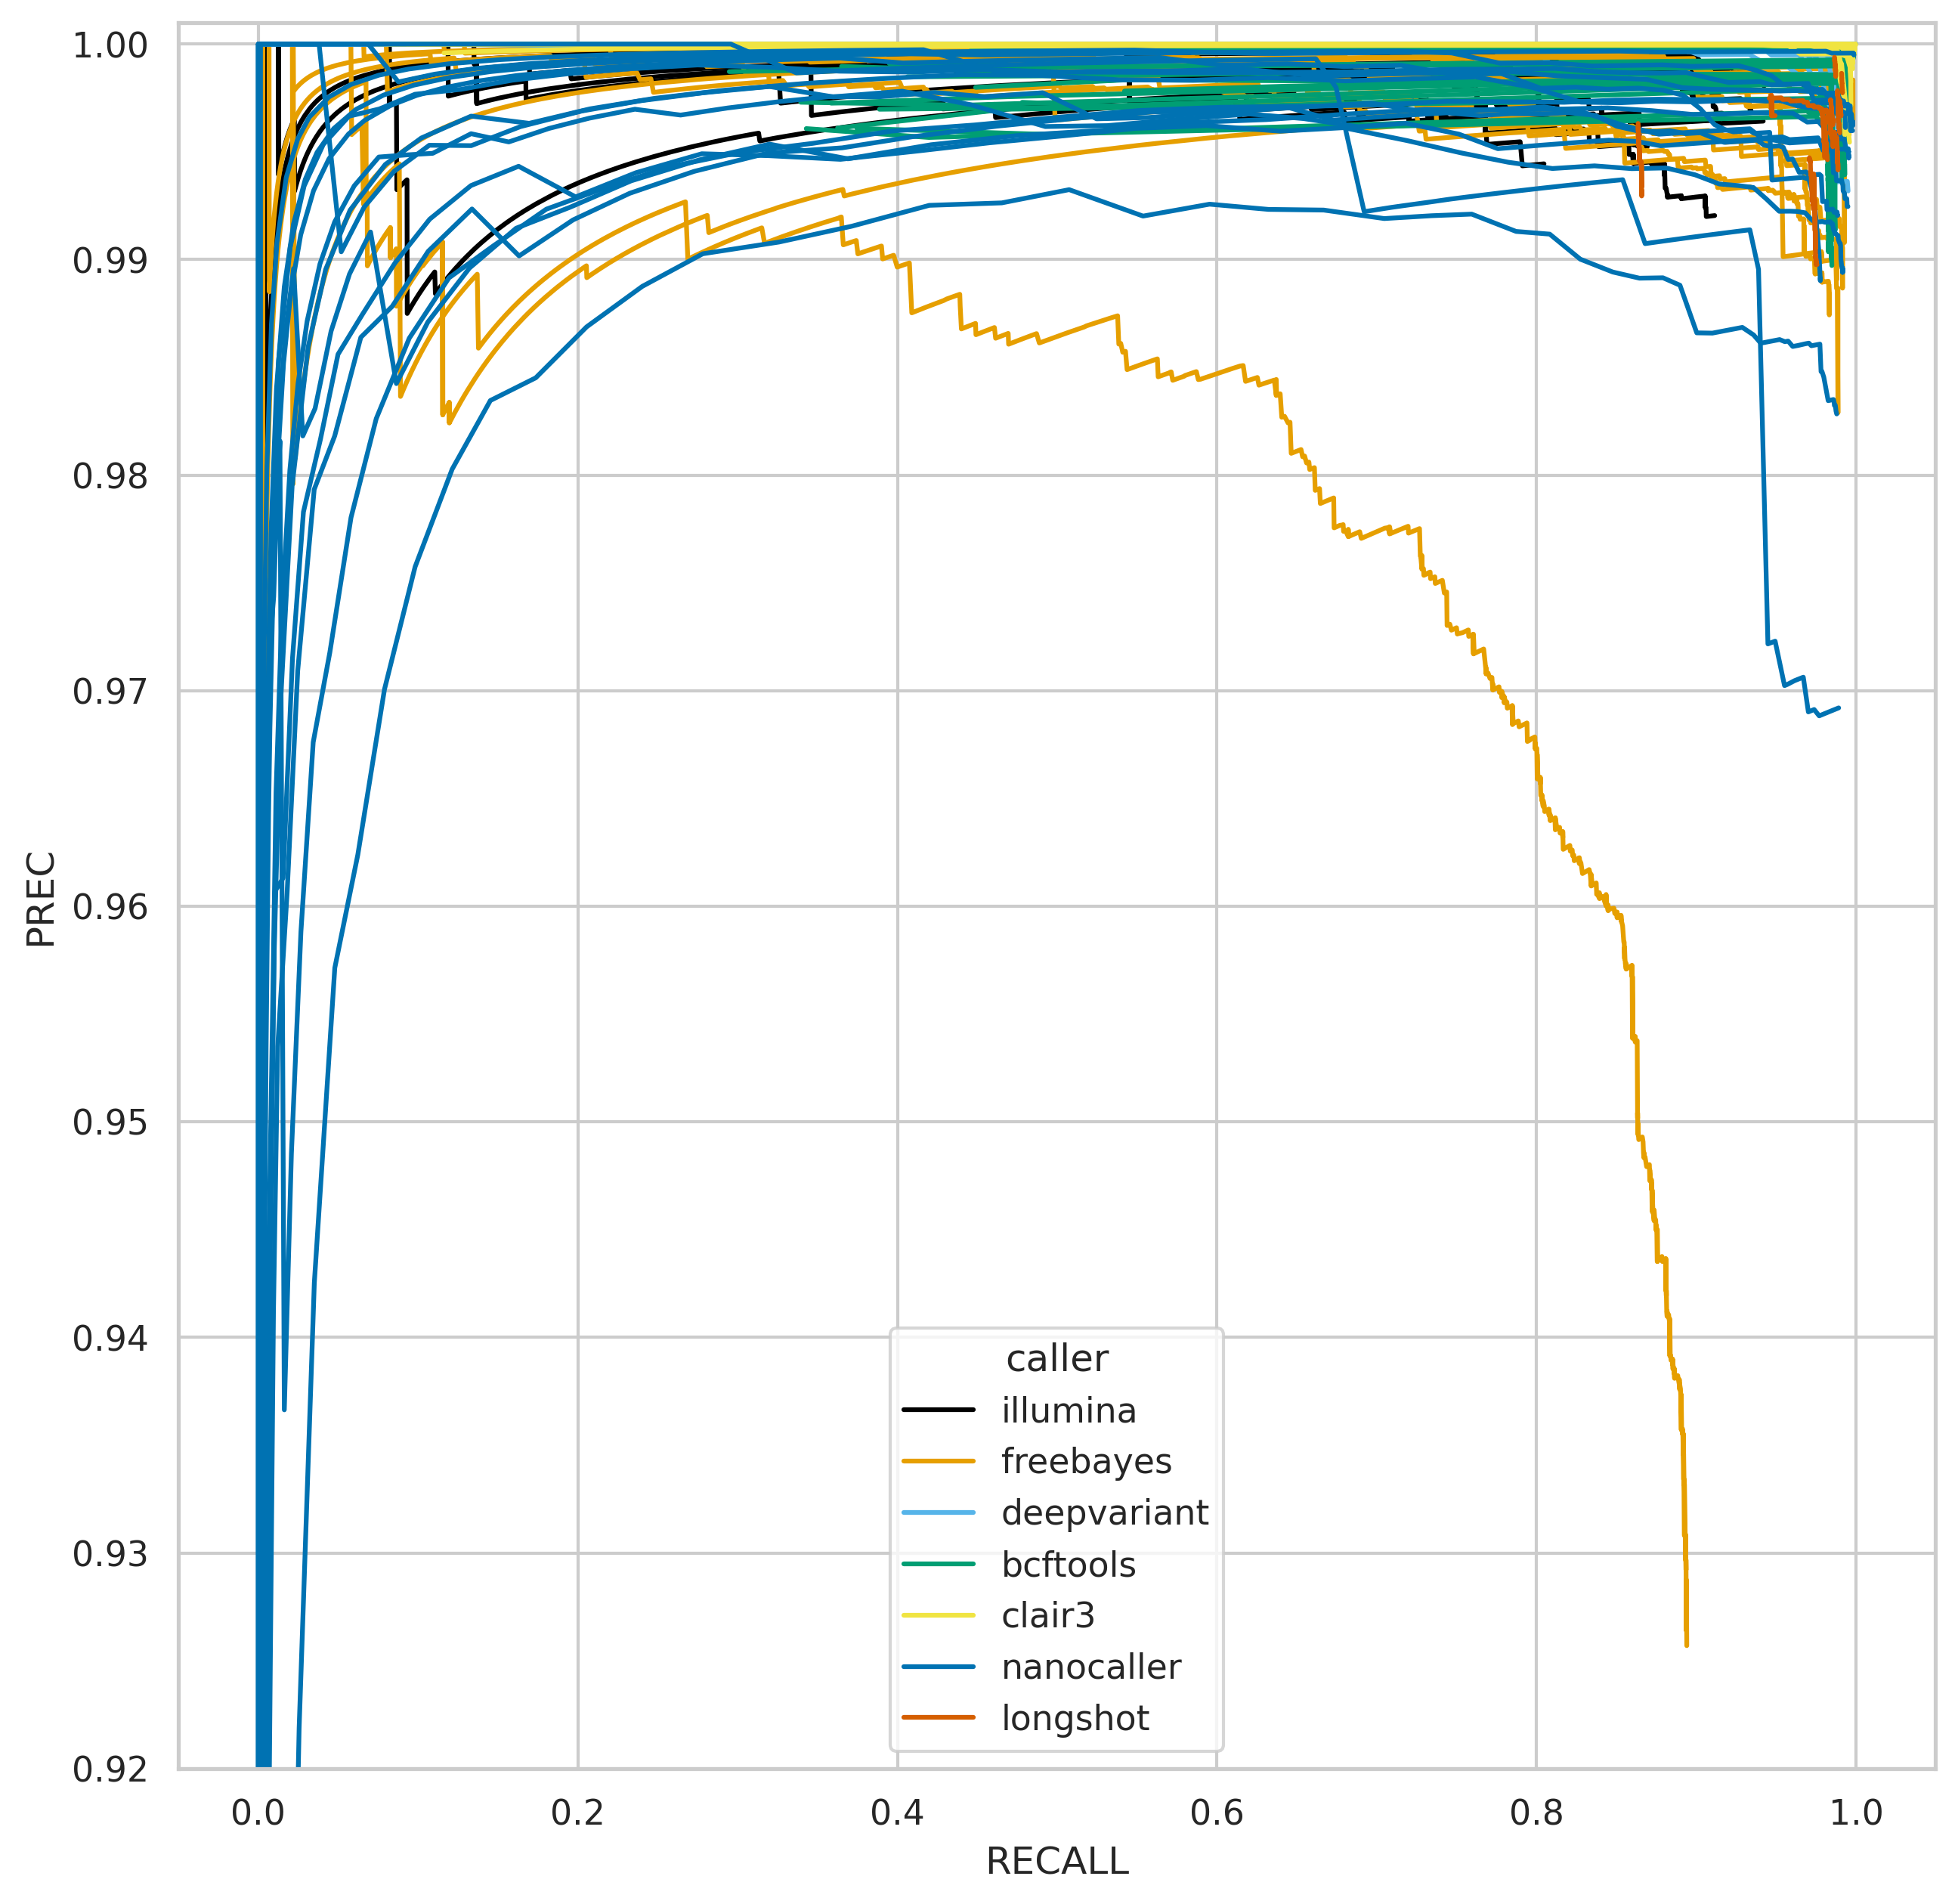

In [30]:
data = pr_df.query("VAR_TYPE == 'SNP' and mode == 'simplex' and model in ['hac', 'illumina']")
data = data[data.index % 2 != 1]
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
sns.lineplot(
    x="RECALL",
    y="PREC",
    data=data,
    hue="caller",
    units="sample",
    estimator=None,
    ax=ax,
    palette=cud(),
)
ax.set_ylim((0.92, 1.001))

In [31]:
import requests

In [34]:
dist_mtx = "/data/scratch/projects/punim2009/NanoVarBench/results/truth/ATCC_BAA-679__202309/distances.tsv"

In [33]:
def fetch_genome_checkm_info(acc: str) -> float:
    """Fetch the CheckM info of a genome from the NCBI assembly summary"""
    url = f"https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/{acc}/dataset_report"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to fetch genome completeness for {acc}")
        print(response.text)
        return 0.0

    data = response.json()
    report = data["reports"][0]
    assembly_status = report.get("assembly_info", {}).get("assembly_status")
    if assembly_status is None:
        print(f"Assembly status not found for {acc}")
    if assembly_status.lower() == "":
    checkm_info = report.get("checkm_info")
    if checkm_info is None:
        print(
            f"CheckM info not found for {acc}, assuming 100% completeness and 0% contamination..."
        )
        return 100.0, 100.0, 0.0
    try:
        completeness_percentile = float(checkm_info["completeness_percentile"])
    except KeyError:
        print(f"Completeness percentile not found for {acc}")
        completeness_percentile = 100.0
    try:
        completeness = float(checkm_info["completeness"])
    except KeyError:
        print(f"Completeness not found for {acc}")
        completeness = 100.0
    try:
        contamination = float(checkm_info["contamination"])
    except KeyError:
        print(f"Contamination not found for {acc}, using 0.0%")
        contamination = 0.0
    return completeness_percentile, completeness, contamination

In [35]:
max_distance = 0.01
min_distance = 0.002
with open(dist_mtx, "r") as f:
    distances = []
    for i, line in enumerate(f):
        fields = line.strip().split("\t")
        fname = Path(fields[0]).name
        acc = "_".join(fname.split("_", maxsplit=2)[:2])

        dist = float(fields[2])
        if min_distance <= dist <= max_distance:
            distances.append((dist, i, acc))

In [37]:
min_completeness = 90
max_contamination = 5
min_completeness_percentile = 25
dists_that_pass_quality = []
for dist, i, acc in distances:
    completeness_percentile, completeness, contamination = fetch_genome_checkm_info(
        acc
    )
    passes_quality_check = (
        completeness >= min_completeness
        and contamination <= max_contamination
        and completeness_percentile >= min_completeness_percentile
    )
    if passes_quality_check:
        dists_that_pass_quality.append(
            (dist, i, completeness, contamination, completeness_percentile)
        )

CheckM info not found for GCF_001710185.1, assuming 100% completeness and 0% contamination...
